In [1]:
import sys, os
# 1) Disable any GPU
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# 2) Turn off oneDNN (Intel’s optimizations often emit AVX2/AVX512 ops)
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# 3) Disable MKL (if your TF was linked against it)
os.environ['TF_DISABLE_MKL'] = '1'

# 4) Disable XLA JIT (can also introduce tricky codegen)
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'
os.environ['TF_USE_XLA'] = '0'

# 5) Quiet down logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# 6) Pin OpenMP/MKL threads to 1 to avoid parallelism bugs
os.environ['OMP_NUM_THREADS']  = '1'
os.environ['MKL_NUM_THREADS']  = '1'
os.environ['TF_NUM_INTRAOP_THREADS']  = '1'
os.environ['TF_NUM_INTEROP_THREADS']  = '1'

import tensorflow as tf

sys.path.append('..')
hls4ml_catapult_path = '/home/manuelbv/hls4ml_catapult'
sys.path = [hls4ml_catapult_path] + sys.path

# Import datetime to get today's date
from datetime import datetime

""" Let's add our custom netsurf code """
import netsurf

""" Get netsurf path """
import os 
parent_dir = os.path.dirname(os.path.dirname(os.path.abspath(netsurf.__file__)))

Adding /mnt/raid0/asic/projects/NU/netsurf/manuelbv to sys.path
[INFO] - Added qkeras to sys.path from /mnt/raid0/asic/projects/NU/netsurf/manuelbv/qkeras
[INFO] - Loaded theme: default
                        ▘▛ ▝     ▗ 
   𐌍 ↠⌾↞ 𐌃 𐌖 𐌔     ▙▝▘▘  ▞ ▗    ▛  
                              ▚▝▜  

Logging to file: /home/manuelbv/.nodus/nodus_20250421_124436.log


-- Date: 21/Apr/2025
╭───────┬─────────────╮
╰ INFO ─┤ 12:44:36.64 │ - Nodus initialized
        │ 12:44:36.64 │ - Nodus version: 0.1.0
        │ 12:44:36.67 │ - Nodus imported
        │ 12:44:36.67 │ - Jobs imported
        │ 12:44:36.67 │ - JobManager imported
        │ 12:44:36.67 │ - Nodus ready to use


Found config file: /home/manuelbv/.netsurf/config


        │ 12:44:37.99 │ - Created jobs table in NodusDB instance 'netsurf_db'
        │ 12:44:37.99 │ - Created job_dependencies table in NodusDB instance 'netsurf_db'
        │ 12:44:37.99 │ - Added NodusDB instance 'netsurf_db' linked to database 'netsurf_db'


In [ ]:
import pergamos as pg

benchmarks = ['mnist_fnn_lite', 'smartpixel_large',  'tinyml_anomaly_detection',] #,] #'keyword_spotting',  'fashion_mnist_hls4ml'
# Set variables
qscheme = "q<6,2,1>"
pruning = 0.125
prerank = True


""" First of all, let's define a quantization Scheme """
Q = netsurf.QuantizationScheme(qscheme)
print(Q)

# Set filename
benchmarks_dir = os.path.join(parent_dir, 'benchmarks')
datasets_dir = os.path.join(parent_dir, 'datasets')

filename = f"7_HLS_{Q._scheme_str.no_special_chars()}_{'_'.join(benchmarks)}_prune{str(pruning).replace('.','_')}.html"
print(filename)
doc = pg.Document(filename, theme="default")
doc.required_scripts.add('mathjax')


""" Add a title to the document """
doc.append(pg.Markdown(f"""# Benchmarks Quantization Assertion
> Author: Manuel B Valentin

> Creation date: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

> Project: netsurf

> Used packages: netsurf, tensorflow, numpy, matplotlib, pergamos
        
"""))

# Add a tab container
tabs = pg.TabbedContainer({'Motivation': [], 
                        'Pre-training analysis': [],
                        'Training': [],
                            'Post-Training': [],
                        'BER Injection': [],
                        'Conclusions': []})

# Get individual tabs
tabmotivation = tabs['Motivation']
tabpretraining = tabs['Pre-training analysis']
tabtraining = tabs['Training']
tabposttraining = tabs['Post-Training']
tabber = tabs['BER Injection']
tabconclusions = tabs['Conclusions']

# Add to documnt
doc.append(tabs)

# Add a markdown description of what we want to achieve with this report in the first tab
md = r"""
## 1. Loss Taylor expansion

Given a loss function $\mathcal{L}(w)$, where $w$ is the vector of all weights in the network, the Taylor expansion around some point $w_0$ (say, the trained weights) for a small perturbation $\Delta w$ is:

$$\mathcal{L}(w_0 + \Delta w) \approx \mathcal{L}(w_0) + \nabla \mathcal{L}(w_0)^T \Delta w + \frac{1}{2} \Delta w^T H \Delta w$$

Where:

* $\nabla \mathcal{L}(w_0)$ is the gradient vector of the loss at w_0
* $H$ is the Hessian matrix, i.e. $H = \nabla^2 \mathcal{L}(w_0)$

---

## 2. If the model is trained??

If the model has been well trained, then:

$\nabla \mathcal{L}(w_0) \approx 0$

Because you're sitting near a (local) minimum.

This removes the linear term:
$\mathcal{L}(w_0 + \Delta w) - \mathcal{L}(w_0) \approx \frac{1}{2} \Delta w^T H \Delta w$

So the change in loss caused by a perturbation $\Delta w$ is approximately:
$\Delta \mathcal{L} \approx \frac{1}{2} \Delta w^T H \Delta w$

---

## 3. Interpretation for bit flips

A bit flip in the quantized weights causes a small but structured change in the weights:

* Say, flipping the 3rd bit in weight $w_i$ causes it to change by $\delta_i$, so:

$\Delta w = \begin{bmatrix}
0 \\ \cdots \\ \delta_i \\ \cdots \\ 0
\end{bmatrix}$

Then the loss increase is (approximately):
$\Delta \mathcal{L} \approx \frac{1}{2} \delta_i^2 H_{ii}$

If multiple bits are flipped across weights, you sum their pairwise interactions via H, including off-diagonal terms (if not ignored).

--- 

## 4. Implications for ranking

This approximation motivates ranking bit positions (or weights) by:

* $\delta^2 \cdot H_{ii}$: bit-flip magnitude times curvature
* This is the FKeras method: estimates $H_{ii}$ and ranks accordingly
* You could generalize it to your method:
$\text{Impact} \cdot H$, not just gradients

---

## 5. When does this approximation hold?

?? Works well when:

* Bit-flip magnitude is small (i.e., local region)
* Model is near a minimum
* Hessian is stable (not exploding)

?? Fails when:

* Model isn??t trained well (gradient is large)
* Loss surface is highly non-quadratic

---

## Summary

The formula:
$\Delta \mathcal{L} \approx \frac{1}{2} \Delta \mathbf{w}^T H \Delta \mathbf{w}$

tells us how bit-flips propagate into loss increases, and explains why the Hessian is so powerful for ranking robustness. 
It encodes:

* How impactful a perturbation is (via $\delta$)
* How sensitive the loss is locally (via $H$)

"""

# Create markdown
md = pg.Markdown(md)

# Add to the first tab
tabmotivation.append(md)

""" Add quantization container to doc report """
tabpretraining.extend(Q.html())

""" Save doc to file (we save after adding each element) """
doc.save(filename)

# Let's create a container for all benchmarks 
benchmark_ct = pg.CollapsibleContainer("🧺 Benchmarks", layout='vertical')

# And another one for tabtraining
benchmark_sessions_ct = pg.CollapsibleContainer("🧺 Benchmarks", layout='vertical')

# And another one for tabposttraining
benchmark_posttraining_ct = pg.CollapsibleContainer("🧺 Benchmarks", layout='vertical')

# And yet another for "BER Injection"
benchmark_ber_ct = pg.CollapsibleContainer("🧪 Experiments", layout='vertical')

""" Add to documnt """
tabpretraining.append(benchmark_ct)

""" Add """
tabtraining.append(benchmark_sessions_ct)

""" Add """
tabposttraining.append(benchmark_posttraining_ct)

""" Add """
tabber.append(benchmark_ber_ct)

# Define benchmarks to analyze
#benchmarks = ['dummy', 'mnist_hls4ml', 'autompg', 'smartpixel_small', 'smartpixel_large',
#              'cifar10', 'mnist_lenet5', 'ECONT_AE'
# 'cifar100', 'svhn', 'fashion_mnist', 'imdb', 'reuters', 'boston_housing']
# TODO: Fix visualization/contrast for cifar10
# TODO: mnist_lenet5 seems to be working (good accuracy), but I'm not too happy about the alphas/betas. Some layers still have a big portion outside of the valid interval

config_per_methods = netsurf.config.config_per_method
protection_range = netsurf.config.DEFAULT_PROTECTION #(0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4) 
ber_range = (0.001, 0.005, 0.01, 0.05, 0.1, 0.15) #netsurf.config.DEFAULT_BER

#methods = ['qpolar', 'qpolargrad', 'bitwise_msb', 'random', 'hirescam_norm', 
#           'hiresdelta', 'hessian', 'hessiandelta', 'weight_abs_value']
methods = ['qpolargrad'] #['laplace', 'hessian', 'fisher', 'bitwise_msb', 'random', 'grad_norm', 'graddelta', 'weight_abs_value'] # 'qpolar', 'qpolargrad', 

exps = {}
for benchmark_name in benchmarks:
    # Create benchmark object 
    bmk = netsurf.get_benchmark(benchmark_name, Q,  benchmarks_dir = benchmarks_dir,
                                datasets_dir = datasets_dir, pruning = pruning,
                                load_weights = False)

    # Add benchmark html to container (this includes model + dataset htmls)
    # (run before training the model...)
    #benchmark_ct.append(bmk.html())

    # save doc
    doc.save(filename)

    # Now let's prepare the data
    nsample_mod = 48 if 'ECON' in bmk.name else -1
    XYTrain = netsurf.utils.prepare_data(bmk, subset = 'train', nsample_mod = nsample_mod)

    # # Initialize the uncertainty profiler (pre-training)
    # pre_robustness_sgn_path = os.path.join(bmk.model_dir, 'uncertainty_signatures', f'{benchmark_name}.pretraining.netsurf.sgn')
    # try:
    #     pre_robustness_sgn = netsurf.UncertaintyProfiler.profile(bmk.model, XYTrain, bmk.model.loss, 
    #                                                             batch_size = 2000, filepath = pre_robustness_sgn_path,
    #                                                             verbose = True)
    #     # Save 
    #     pre_robustness_sgn.save_to_file(pre_robustness_sgn_path)
    # except:
    #     pass

    # Add profile to tabpretraining
    # benchmark_ct.append(pre_robustness_sgn.html())

    # Now we can reload the weights (After the profiling)
    bmk.load_weights(verbose = True)

    # TRAINING - SESSION
    # Try to get a session (if not, train)
    sess = netsurf.get_training_session(bmk, show_plots = False, plot = True, verbose = True)

    # save doc
    doc.save(filename)

    # Create a container for this bmk in tabtraining
    bmk_sess_ct = pg.CollapsibleContainer(benchmark_name, layout='vertical')

    # Add session to tabtraining
    bmk_sess_ct.append(sess.html())

    # And add to benchmarks in tabtraining
    benchmark_sessions_ct.append(bmk_sess_ct)

    # Add benchmark again to post-training to check how the weights changed
    #benchmark_posttraining_ct.append(bmk.html())

    # Initialize the uncertainty profiler (post-training)
    # try:
    #     post_robustness_sgn_path = os.path.join(bmk.model_dir, 'uncertainty_signatures', f'{benchmark_name}.posttraining.netsurf.sgn')
    #     post_robustness_sgn = netsurf.UncertaintyProfiler.profile(bmk.model, XYTrain, bmk.model.loss, 
    #                                     batch_size = 2000, verbose = True, filepath = post_robustness_sgn_path)

    #     # Save 
    #     post_robustness_sgn.save_to_file(post_robustness_sgn_path)
    # except:
    #     pass

    # Add profile to tabposttraining
    # benchmark_posttraining_ct.append(post_robustness_sgn.html())

    # Let's compare the divergence between the profiles
    # div_profile = netsurf.ProfileDivergence.from_signatures(pre_robustness_sgn, post_robustness_sgn)

    #div_profile.plot_divergence_summary()
    #div_profile.plot_advanced_divergence_summary()

    """ Save doc to file (we save after adding each element) """
    doc.save(filename)

    # Create a container for this benchmark in "BER Injection"
    bmk_ber_ct = pg.CollapsibleContainer(benchmark_name, layout='vertical')

    # Add to tabber
    benchmark_ber_ct.append(bmk_ber_ct)

    # Create another container to store the individual results of the experiments
    exp_individual_ct = pg.CollapsibleContainer("🎁 Individual results", layout='vertical')
    bmk_ber_ct.append(exp_individual_ct)

    # Create our ranker profiler (empty)
    rankers_bucket = netsurf.RankingComparator()

    # Loop thru methods
    exps[benchmark_name] = {}
    for method_alias in methods:
        #########################################################################
        # 0. Create the directory for the experiment (ranking, results, etc.)
        #########################################################################
        method = config_per_methods[method_alias]['method']
        method_dir = os.path.join(bmk.experiments_dir, method)

        #########################################################################
        # 1. Create the ranker
        #########################################################################
        rkr = rankers_bucket.build_ranker(method, Q, config = config_per_methods[method], 
                                        path = method_dir,
                                        is_baseline = (method == 'qpolargrad'))

        # Get the exp dir from the ranker (with the hash)
        exp_dir = rkr.path

        #################################################################
        # 1. Perform ranking according to method
        #################################################################
        # Rank weights 
        ranking = rkr.rank(bmk.model, *XYTrain, verbose = True)
        # Save rank to csv file 
        ranking.save(overwrite = False)

        #################################################################
        # 2. Create experiment object
        #################################################################
        exp = netsurf.Experiment(bmk, ranking, num_reps = 100, 
                                ber_range = ber_range, 
                                protection_range = protection_range, 
                                path = exp_dir,
                                verbose = True)

        # Print experiment info 
        print(exp)

        #################################################################
        # 3. Run experiment with given ranking and for whatever 
        #       range of protection and rad 
        #################################################################
        #batch_size = 1000,
        exp.run_experiment(bmk, XYTrain,
                        batch_size = None,
                        ber_range = ber_range, 
                        protection_range = protection_range, 
                        rerun = False)
        
        # Add experiment to container
        #exp_individual_ct.append(exp.html())

        # Save experiment object
        exp.save()

        # Add to dict
        exps[benchmark_name][method] = exp

        """ Save doc to file (we save after adding each element) """
        doc.save(filename)

    """ Now perform the comparison of rankers """
    #df = rankers_bucket.compare_rankers(granularity = 0.01, bootstrap = False)

    # Add comparison to container
    #bmk_ber_ct.append(rankers_bucket.html())

    # Save doc 
    #doc.save(filename)

    # # Save the rankers_bucket
    # rankers_comparison_filepath = os.path.join(bmk.experiments_dir, 'ranking_comparison.csv')
    # rankers_bucket.save_to_csv(rankers_comparison_filepath)

    # """ Create Experiment Comparator """
    # exp_comp = netsurf.ExperimentComparator(list(exps.values()))
    #df = ExperimentComparator.compute_ranking_distribution(res)


🧮 <QuantizationScheme(q<6,2,1>)> obj @ (0x7fa98dde6380):
    Total number of bits (m): 6
    Integer bits         (n): 2
    Float bits           (f): 3
    Signed
    Range: (-4, 3.875)
    Min step: 0.125
    Format: Sxx.xxx

7_HLS_q6_2_1_mnist_fnn_lite_fashion_mnist_hls4ml_smartpixel_large_tinyml_anomaly_detection_prune0_125.html


╭───────┼─────────────┤
╰ BMK ──┤ 16:17:14.13 │ - Initializing benchmark object mnist_fnn_lite
        │ 16:17:14.13 │ - Loss categorical_crossentropy found in tf.keras.losses with definition <function categorical_crossentropy at 0x7fa9da28e710>.
        │ 16:17:14.13 │ - Adding custom metric categorical_accuracy with definition CategoricalAccuracy(name=categorical_accuracy,dtype=float32).
        │ 16:17:14.25 │ - Benchmark object mnist_fnn_lite initialized
╭───────┼─────────────┤
╰ DATA ─┤ 16:17:16.93 │ - Normalizing dataset (input) using quantizer range (-4, 3.875)
╭───────┼─────────────┤
╰ BMK ──┤ 16:17:18.39 │ - No path provided, looking for latest h5 file at default model path: /mnt/raid0/asic/projects/NU/netsurf/manuelbv/benchmarks/mnist_fnn_lite/q6_2_1/pruned_0.125_159569_qflatten_dense10u_qapplyalpha_quantized_relu_dense10u_qsoftmax/models
        │ 16:17:18.39 │ - Looking for file /mnt/raid0/asic/projects/NU/netsurf/manuelbv/benchmarks/mnist_fnn_lite/q6_2_1/pruned_0.125_15956

+-------------------------------------------------------------------------------+
| Method: qpolargrad                                                            |
| Experiment: mnist_fnn_lite_qpolargrad_q<6,2,1>_descending_absolute_value_True |
+-------------------------------------------------------------------------------+
| Ranking Config:                                                               |
+-------------------------------------------------------------------------------+
|    method: qpolargrad                                                         |
|    ascending: False                                                           |
|    batch_size: 96                                                             |
|    suffix:                                                                    |
|    quantization: q<6,2,1>                                                     |
|    normalize_score: False                                                     |
|    use_delta_a

╭───────┼─────────────┤
╰ INFO ─┤ 16:17:26.62 │ - Loaded results from /mnt/raid0/asic/projects/NU/netsurf/manuelbv/benchmarks/mnist_fnn_lite/q6_2_1/pruned_0.125_159569_qflatten_dense10u_qapplyalpha_quantized_relu_dense10u_qsoftmax/experiments/qpolargrad/eNo9jMsKwjAQRf9l1tnoomARfyVMk8kD0sRmJloq_rsjiLvL4Zz7Aly4lSFkH1gGwSx9kAFkR9XnGmEOWFjJguKS5Xyoc5kMrCSpeZhhu7eCPXb0YKC2vmJRybJrnf71NrBKPlByq9_mOpmzOd204BFC3pXpHkzWUxG0yPZJOSb5Pbw_6no7Pg/results.csv
        │ 16:17:26.69 │ - Loaded metrics from /mnt/raid0/asic/projects/NU/netsurf/manuelbv/benchmarks/mnist_fnn_lite/q6_2_1/pruned_0.125_159569_qflatten_dense10u_qapplyalpha_quantized_relu_dense10u_qsoftmax/experiments/qpolargrad/eNo9jMsKwjAQRf9l1tnoomARfyVMk8kD0sRmJloq_rsjiLvL4Zz7Aly4lSFkH1gGwSx9kAFkR9XnGmEOWFjJguKS5Xyoc5kMrCSpeZhhu7eCPXb0YKC2vmJRybJrnf71NrBKPlByq9_mOpmzOd204BFC3pXpHkzWUxG0yPZJOSb5Pbw_6no7Pg/metrics.json
        │ 16:17:26.71 │ - Experiment is finished. Nothing else to run.
╭───────┼─────────────┤
╰ WARN ─┤ 16:17:26.71 │ - Expe

Extracting base weight table for hls4ml_cnn... 32/32: [==============================>] [00:00:00]          


: 

In [ ]:
bmk.model.summary()

In [ ]:
""" 
    Injection performance metrics 
     (This class computes the metrics derived from the results obtained 
     from the bit injection experiments.)
     Metrics are:
      - AUC per protection level
      - cAUC (cumulative AUC) per protection level
      - dynamicRanking (this is the ranking probability after bootstrapping)

      However, we will NOT compute this as single curves. We will instead
       interpolate to get a grid to get a 3d distribution.

    We will also measure things like the entropy of these distributions, for instance.

"""
from dataclasses import dataclass, field
from typing import List, Optional, Dict, Union

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.patches import Patch
from matplotlib.colors import to_rgb
from matplotlib.colors import ListedColormap

from netsurf.core.experiments import ResultSpace, Experiment

from scipy.stats import skew, kurtosis, entropy
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import cKDTree, Voronoi

import matplotlib.colors as mcolors
from shapely.geometry import Polygon as ShapelyPolygon, box
from matplotlib.patches import Polygon

import pergamos as pg
from pergamos import html

@dataclass
class InjectionPerformanceMetrics:
    # Resolution for the grid interpolation in the order [protection, BER]
    granularity: List[float] = field(default_factory=lambda: [0.01, 0.01])
    # 1D arrays for the grid points
    protection_edges: np.ndarray = None
    ber_edges: np.ndarray = None
    name: str = "InjectionPerformanceMetrics"

    # Dictionary containing moment grids for each metric (loss + all other metrics)
    # Each entry is a dict with keys: 'mean', 'std', 'skewness', 'kurtosis', 'count'
    moment_grids: Dict[str, Dict[str, np.ndarray]] = field(default_factory=dict)
    field_grids: Dict[str, Dict[str, np.ndarray]] = field(default_factory=dict)
    ranking_moment_grids: Dict[str, Dict[str, np.ndarray]] = field(default_factory=dict)
    ranking_field_grids: Dict[str, Dict[str, np.ndarray]] = field(default_factory=dict)
    overall_stats: Dict[str, Dict[str, np.ndarray]] = field(default_factory=dict)

    _ICON = "🥇"

    def keys(self):
        """
        Returns the keys of the moment grids.
        """
        return list(self.moment_grids.keys())
    
    def __len__(self):
        """
        Returns the number of moment grids.
        """
        return len(self.moment_grids)
    
    def __iter__(self):
        """
        Returns an iterator over the moment grids.
        """
        return iter(self.moment_grids.items())
    

    # Get items
    def __getitem__(self, key: Union[str|int]) -> Dict[str, np.ndarray]:
        if isinstance(key, str):
            return self.moment_grids[key], self.field_grids[key], self.ranking_moment_grids[key], self.ranking_field_grids[key], self.overall_stats[key]
        elif isinstance(key, int):
            keys = self.keys()
            if key >= len(keys):
                raise KeyError(f"Index {key} out of range. Available keys: {keys}")
            return self.moment_grids[keys[key]], self.field_grids[keys[key]], self.ranking_moment_grids[keys[key]], self.ranking_field_grids[keys[key]], self.overall_stats[keys[key]]
        else:
            raise TypeError(f"Key must be str or int, got {type(key)}")
        
    @staticmethod
    def from_range(protection_range: List[float], ber_range: List[float], granularity: Optional[List[float]] = None):
        """
        Creates a grid of protection and BER values based on the specified ranges and granularity.
        """
        if granularity is None:
            granularity = [0.01, 0.01]
        gp, gb = granularity

        # Create grid arrays for protection and BER
        prot_edges = np.arange(protection_range[0], protection_range[1] + gp, gp)
        ber_edges = np.arange(ber_range[0], ber_range[1] + gb, gb)

        return InjectionPerformanceMetrics(
            granularity=granularity,
            protection_edges=prot_edges,
            ber_edges=ber_edges
        )

    @staticmethod
    def fill_nan_with_griddata(X, Y, Z, method='cubic'):
        """
        Fill NaN values in a 2D array Z using scipy.interpolate.griddata on the valid points.
        
        Args:
            X (np.ndarray): 2D array of x-coordinates (meshgrid).
            Y (np.ndarray): 2D array of y-coordinates (meshgrid).
            Z (np.ndarray): 2D array of z-values, with possible NaNs.
            method (str): Interpolation method ('linear', 'nearest', 'cubic').
            
        Returns:
            Z_filled (np.ndarray): A copy of Z with NaNs replaced by interpolated values.
        """
        # Flatten the arrays
        x_flat = X.ravel()
        y_flat = Y.ravel()
        z_flat = Z.ravel()
        
        # Identify valid points (non-NaN)
        mask = ~np.isnan(z_flat)
        
        # Coordinates and values of the valid points
        points_valid = np.column_stack([x_flat[mask], y_flat[mask]])
        values_valid = z_flat[mask]
        
        # All points (including where we need interpolation)
        points_all = np.column_stack([x_flat, y_flat])
        
        # Perform griddata interpolation
        z_filled_flat = griddata(points_valid, values_valid, points_all, method=method)
        
        # Reshape to original grid shape
        Z_filled = z_filled_flat.reshape(Z.shape)
        
        return Z_filled

    def compute_moments(self, data, z, x = 'protection', y = 'ber', x_bins = None, y_bins = None):
        
        # 1. Create bin labels for x and y
        df = data.copy()  # avoid modifying the original DataFrame
        df['x_bin'] = pd.cut(df[x], bins=x_bins, include_lowest=True)
        df['y_bin'] = pd.cut(df[y], bins=y_bins, include_lowest=True)

        # 2. Group by these bins
        grouped = df.groupby(['x_bin', 'y_bin'], observed = False)[z]

        # 3. Compute basic aggregates: mean, std, count
        stats_df = grouped.agg(['mean', 'std', 'count']).reset_index()

        # 4. Compute skew and kurtosis. We use apply() on the grouped object.
        #    We then match these values back into stats_df via .values
        stats_df['skew'] = grouped.apply(lambda s: skew(s, bias=False)).values
        stats_df['kurtosis'] = grouped.apply(lambda s: kurtosis(s, bias=False)).values

        # 5. Pivot each statistic into a 2D table (y_bin as rows, x_bin as columns)
        mean_grid = stats_df.pivot(index='y_bin', columns='x_bin', values='mean')
        std_grid = stats_df.pivot(index='y_bin', columns='x_bin', values='std')
        skew_grid = stats_df.pivot(index='y_bin', columns='x_bin', values='skew')
        kurt_grid = stats_df.pivot(index='y_bin', columns='x_bin', values='kurtosis')
        count_grid = stats_df.pivot(index='y_bin', columns='x_bin', values='count')

        # 6. Fill NaN values using griddata interpolation
        X, Y = np.meshgrid(self.protection_edges[:-1], self.ber_edges[:-1])
        mean_grid = self.fill_nan_with_griddata(X, Y, mean_grid.values)
        std_grid = self.fill_nan_with_griddata(X, Y, std_grid.values)
        skew_grid = self.fill_nan_with_griddata(X, Y, skew_grid.values)
        kurt_grid = self.fill_nan_with_griddata(X, Y, kurt_grid.values)
        count_grid = self.fill_nan_with_griddata(X, Y, count_grid.values)
        
        # 6. Return them in a dictionary
        return X, Y, {
            'mean': mean_grid,
            'std': std_grid,
            'skewness': skew_grid,
            'kurtosis': kurt_grid,
            'count': count_grid
        }
    

    # Fields computation (gradient, laplacian, hessian, etc.)
    def compute_fields(self, moment_grid, x_grid = None, y_grid = None):
        """
        Compute local geometric descriptors of a 2D scalar field Z using finite differences.

        These include:
        - 'mean': The original surface Z (typically average accuracy in a grid).
        - 'gradient': The magnitude of the local change in Z, i.e., how fast performance changes locally.
        - 'laplacian': The sum of second-order derivatives, indicating concave/convex regions (sources/sinks).
        - 'eigen1', 'eigen2': The principal curvatures (eigenvalues of the Hessian), showing directional curvature.
        - 'det': Determinant of the Hessian matrix. Positive => local minima/maxima, Negative => saddle point.
        - 'condition': Ratio |λ₁| / |λ₂| of Hessian eigenvalues, indicating anisotropy in curvature.

        These fields help visualize and quantify how performance evolves in the (Protection, BER) space.
        """
        if x_grid is not None and y_grid is not None:
            dx = x_grid[0,1] - x_grid[0,0]
            dy = y_grid[1,0] - y_grid[0,0]
        else:
            dx = dy = 1.0  # fallback for unit spacing
            # Let the user know though
            netsurf.warning("[!] No x_grid or y_grid provided. Using unit spacing for dx and dy. Please note that this will most " \
            "likely affect the results, since fields depend on the actual spacing of the grid.")

        grad_y, grad_x = np.gradient(moment_grid, dy, dx)
        grad_mag = np.sqrt(grad_x**2 + grad_y**2)
        d2Z_dx2 = np.gradient(grad_x, dx, axis=1)
        d2Z_dy2 = np.gradient(grad_y, dy, axis=0)
        d2Z_dxdy = np.gradient(grad_x, dy, axis=0)
        lap = d2Z_dx2 + d2Z_dy2
        trace = lap
        det = d2Z_dx2 * d2Z_dy2 - d2Z_dxdy**2
        disc = np.sqrt(np.maximum(trace**2 - 4 * det, 0))
        eig1 = (trace + disc) / 2
        eig2 = (trace - disc) / 2
        cond = np.abs(eig1) / (np.abs(eig2) + 1e-12)
        return {
            'gradient': grad_mag, 'laplacian': lap,
            'eigen1': eig1, 'eigen2': eig2, 'det': det, 'condition': cond
        }
    
    
    @staticmethod
    def compute_ranking_moments(ranking: netsurf.core.Ranking,
                                protection_levels: np.ndarray, ber_levels: np.ndarray,
                                mc_reps: int = 20, sample_size: int = 100, seed: int = 42, entropy_bins: int = 30):
        """
        Compute statistical moments (mean, std, skewness, kurtosis, entropy) of protected and unprotected weights/susceptibilities.
        """

        np.random.seed(seed)
        r = ranking.ranking.sort_values('rank', ascending=True)

        moments = {}

        for var in ['value', 'susceptibility']:
            data = r[var].values
            rank_vals = r['rank'].values
            total = len(data)

            shape = (len(ber_levels), len(protection_levels))

            def init_moment_grid():
                return {
                    'mean': np.full(shape, np.nan),
                    'std': np.full(shape, np.nan),
                    'skewness': np.full(shape, np.nan),
                    'kurtosis': np.full(shape, np.nan),
                    'entropy': np.full(shape, np.nan)  # ✅ NEW
                }

            protected_moments = init_moment_grid()
            unprotected_moments = init_moment_grid()

            with netsurf.utils.ProgressBar(total=len(protection_levels), prefix=f'Computing ranking moments for {var}') as pb:

                for j, p in enumerate(protection_levels):
                    k = int(p * total)
                    protected_subset = data[:k] if k > 1 else []

                    if k > 1:
                        protected_moments['mean'][:, j] = np.mean(protected_subset)
                        protected_moments['std'][:, j] = np.std(protected_subset)
                        protected_moments['skewness'][:, j] = skew(protected_subset, bias=False)
                        protected_moments['kurtosis'][:, j] = kurtosis(protected_subset, bias=False)

                        # ✅ Compute entropy for protected
                        hist, _ = np.histogram(protected_subset, bins=entropy_bins, density=True)
                        protected_moments['entropy'][:, j] = entropy(hist + 1e-8)  # avoid log(0)

                    unprotected_subset = data[rank_vals > p]
                    if len(unprotected_subset) < 2:
                        continue

                    for i, ber in enumerate(ber_levels):
                        n_flips = int(ber * len(unprotected_subset))
                        if n_flips < 2:
                            continue

                        samples = [
                            np.random.choice(unprotected_subset, size=min(sample_size, n_flips), replace=False)
                            for _ in range(mc_reps)
                        ]

                        protected_stats = lambda fn: np.mean([fn(s) for s in samples])

                        unprotected_moments['mean'][i, j] = protected_stats(np.mean)
                        unprotected_moments['std'][i, j] = protected_stats(np.std)
                        unprotected_moments['skewness'][i, j] = protected_stats(lambda x: skew(x, bias=False))
                        unprotected_moments['kurtosis'][i, j] = protected_stats(lambda x: kurtosis(x, bias=False))

                        # ✅ Compute entropy for unprotected
                        entropy_vals = []
                        for s in samples:
                            hist, _ = np.histogram(s, bins=entropy_bins, density=True)
                            entropy_vals.append(entropy(hist + 1e-8))
                        unprotected_moments['entropy'][i, j] = np.mean(entropy_vals)

                    pb.update()


            moments[var] = {
                'protected': protected_moments,
                'unprotected': unprotected_moments
            }

        return moments


    # Compute trust overlay 
    def compute_trust_overlay(self, x_grid, y_grid, moment_grid, dx=1, dy=1):
        """
        Compute binary trust masks and magnitude overlays from barycentric strengths.

        - trust_mask[i]: True where ranker i's barycentric strength exceeds the threshold.
        - trust_overlay[i]: Barycentric strength multiplied by trust_mask — preserves dominance magnitude in trusted zones.
        - coverage[i]: Fraction of total grid where trust_mask[i] is True.

        This identifies regions where a ranker is reliably stronger than others (not just marginally winning).
        """
        pass

    # Barycentric strength
    def compute_barycentric_strength(self, Z_all):
        """
        Compute barycentric strength maps for a stack of ranker surfaces.

        Each Z_bary[i] represents the normalized contribution of ranker i at each (x, y) point:
            Z_bary[i] = Z_all[i] / sum(Z_all over rankers)

        This shows the *relative dominance* of each ranker in every region of the grid, forming a simplex (sums to 1).
        """
        Z_bary = Z_all / (np.sum(Z_all, axis=0, keepdims=True) + 1e-12)
        return Z_bary

    # Compute rgb dominance
    def compute_rgb_dominance(self):
        """
        Compute a continuous RGB dominance map that visually encodes ranker preference.

        - Subtracts mean per pixel (centers ranks)
        - Normalizes to unit vectors (direction = dominance vector)
        - Blends colors proportionally using RGB triplets assigned to each ranker

        This provides an intuitive, continuous visual of which ranker dominates where — and by how much.
        """
        pass

    def plot_barycentric_dominance_map(accuracy_grids: dict, smooth=True, sigma=1.0):
        """
        Create a continuous barycentric blend of ranker dominance using RGB interpolation.
        Input:
        - accuracy_grids: dict of {ranker_name: 2D grid (BER x Protection)}
        Output:
        - RGB blended plot with optional smoothing.
        """
        ranker_names = list(accuracy_grids.keys())
        n_rankers = len(ranker_names)
        grids = np.stack([accuracy_grids[k] for k in ranker_names], axis=0)  # (n_rankers, H, W)
        normed = grids / np.sum(grids, axis=0, keepdims=True)  # barycentric normalization

        # Map each ranker to a fixed RGB color
        base_colors = plt.cm.tab10(np.arange(n_rankers))[:, :3]  # RGB
        rgb_map = np.tensordot(normed.transpose(1,2,0), base_colors, axes=([2],[0]))  # shape (H, W, 3)

        if smooth:
            for i in range(3):
                rgb_map[..., i] = gaussian_filter(rgb_map[..., i], sigma=sigma)

        fig, ax = plt.subplots(figsize=(8, 6))
        ax.imshow(rgb_map, origin='lower', aspect='auto')
        ax.set_title("Barycentric RGB Blend of Ranker Strengths")
        ax.set_xlabel("Protection")
        ax.set_ylabel("BER")

        # Legend
        patches = [Patch(color=base_colors[i], label=ranker_names[i]) for i in range(n_rankers)]
        ax.legend(handles=patches, title="Rankers", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        return fig, ax


    def plot_weighted_voronoi(pts, weights, labels, ranker_names, cmap=None):
        """
        Create a weighted Voronoi-like plot where confidence (weights) affects the alpha blending.
        Input:
        - pts: (N, 2) array of (x, y) positions
        - weights: (N,) confidence or strength (0–1)
        - labels: (N,) index of winning ranker
        - ranker_names: list of ranker names
        """
        n_rankers = len(ranker_names)
        if cmap is None:
            cmap = plt.cm.get_cmap('tab10', n_rankers)
        
        fig, ax = plt.subplots(figsize=(8, 6))
        tree = cKDTree(pts)
        
        # Grid for rendering
        x = np.linspace(pts[:, 0].min(), pts[:, 0].max(), 400)
        y = np.linspace(pts[:, 1].min(), pts[:, 1].max(), 400)
        xv, yv = np.meshgrid(x, y)
        grid_pts = np.column_stack([xv.ravel(), yv.ravel()])

        # Query nearest Voronoi center
        dists, idxs = tree.query(grid_pts)
        label_map = labels[idxs]
        alpha_map = weights[idxs]

        image = np.zeros((len(y), len(x), 4))
        for i in range(n_rankers):
            mask = (label_map == i).reshape(len(y), len(x))
            color = np.array(to_rgb(cmap(i)))
            for j in range(3):
                image[..., j] += mask * color[j]
            image[..., 3] += mask * alpha_map.reshape(len(y), len(x))

        ax.imshow(image, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], aspect='auto')
        ax.set_title("Weighted Voronoi of Ranker Dominance")
        ax.set_xlabel("Protection")
        ax.set_ylabel("BER")
        ax.legend(handles=[Patch(color=cmap(i), label=ranker_names[i]) for i in range(n_rankers)],
                title="Rankers", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        return fig, ax

    def plot_voronoi_dominance(self, ber_grid, protection_grid, ranker_index_map, ranker_names, cmap=None):
        """
        Create a Voronoi-style plot for visualizing the dominant ranker across the BER/Protection space.
        """
        H, W = ranker_index_map.shape
        n_rankers = len(ranker_names)

        if cmap is None:
            cmap = plt.cm.get_cmap('tab10', n_rankers)

        # Flatten grids and construct points
        xs = protection_grid.ravel()
        ys = ber_grid.ravel()
        pts = np.column_stack([xs, ys])
        labels = ranker_index_map.ravel()

        # Remove NaNs or infs
        valid = np.isfinite(xs) & np.isfinite(ys)
        pts = pts[valid]
        labels = labels[valid]

        # Use unique points for Voronoi
        _, unique_indices = np.unique(pts, axis=0, return_index=True)
        pts = pts[unique_indices]
        labels = labels[unique_indices]

        # Compute Voronoi diagram
        vor = Voronoi(pts)

        # Plot
        fig, ax = plt.subplots(figsize=(8, 6))
        voronoi_plot_2d(vor, ax=ax, show_vertices=False, show_points=False, line_colors='gray', line_width=0.5)

        for region_idx, point_idx in enumerate(vor.point_region):
            region = vor.regions[point_idx]
            if -1 in region or len(region) == 0:
                continue  # skip unbounded regions
            polygon = [vor.vertices[i] for i in region]
            color = cmap(labels[region_idx])
            patch = plt.Polygon(polygon, color=color, alpha=0.8)
            ax.add_patch(patch)

        ax.set_xlim(xs.min(), xs.max())
        ax.set_ylim(ys.min(), ys.max())
        ax.set_xlabel("Protection")
        ax.set_ylabel("BER")
        ax.set_title("Voronoi Diagram of Ranker Dominance")

        # Add legend
        legend_elements = [Patch(facecolor=cmap(i), label=ranker_names[i]) for i in range(n_rankers)]
        ax.legend(handles=legend_elements, title="Rankers", bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        return fig, ax

    def compute_auc_stats(self, x_grid, y_grid, z_grid):
        """
        Compute AUC statistics for the given metric.
        """
        AUC_per_x = np.trapz(z_grid, x=y_grid, axis=0)

        # Get the maximum AUC value
        max_auc = np.max(z_grid, axis = 0) * (y_grid[0, -1] - y_grid[0, 0])
        # Normalize AUC_per_x by this
        AUC_per_x_norm = AUC_per_x / max_auc

        return {'auc': AUC_per_x, 'auc_norm': AUC_per_x_norm}
    
    def compute_vus_stats(self, x_grid, y_grid, z_grid ):
        """
        Compute VUS statistics for the given metric.
        """

        # First, integrate along the x direction for each row (axis=1)
        integral_x = np.trapz(z_grid, x=x_grid[0,:])

        # Now, integrate the result along the y direction
        volume = np.trapz(integral_x, x=y_grid[:,0])

        # Normalize by max volume
        dx = x_grid[0,-1] - x_grid[0,0]
        dy = y_grid[-1,0] - y_grid[0,0]
        # Get the max volume
        max_volume = np.max(z_grid) * dx * dy
        volume_norm = volume/max_volume

        return {'vus': volume, 'vus_norm': volume_norm}


    """
        Add experiment
    """
    def add_experiment(self, exp: Experiment, granularity: Optional[List[float]] = None, name = None, 
                       mc_reps: int = 20, sample_size: int = 100, seed: int = 42):
        """
        Adds the results of a single experiment to the existing moment grids.
        This is useful for combining multiple experiments or runs.
        """
        # Extract the results from the experiment
        results = exp.results

        if granularity is None:
            granularity = self.granularity
        else:
            # Make sure the granularity matches the existing one
            if any([abs(g - g2) > 1e-5 for g, g2 in zip(granularity, self.granularity)]):
                raise ValueError(f"Granularity mismatch: {granularity} vs {self.granularity}")
        gx, gy = granularity

        # Get the bins 
        protection_edges = self.protection_edges
        if protection_edges is None:
            prot_min, prot_max = results['protection'].min(), results['protection'].max()
            prot_bins = np.arange(prot_min, prot_max + gx, gx)
            prot_edges = np.concatenate(([prot_min - gx/2], (prot_bins[:-1] + prot_bins[1:]) / 2, [prot_max + gx/2]))
            self.protection_edges = prot_edges
        
        
        ber_edges = self.ber_edges
        if ber_edges is None:
            ber_min, ber_max = results['ber'].min(), results['ber'].max()
            ber_bins = np.arange(ber_min, ber_max + gy, gy)
            ber_edges = np.concatenate(([ber_min - gy/2], (ber_bins[:-1] + ber_bins[1:]) / 2, [ber_max + gy/2]))
            
            self.ber_edges = ber_edges

        # Build a combined dictionary for all metrics (loss + other metrics)
        all_metrics = {}
        loss_col = results.loss_name  # assuming _loss holds the name of the loss column
        all_metrics[loss_col] = results[loss_col].values.astype(float)
        for metric in results.metrics:
            all_metrics[metric] = results[metric].values.astype(float)

        moment_grids = {}
        field_grids = {}
        overall_stats = {}

        # Interpolate the results onto the existing grid
        for metric in all_metrics:
            netsurf.info(f"Computing moments and fields for {metric}...")
            x_grid, y_grid, moment_grids[metric] = self.compute_moments(results, metric,
                                                       x = 'protection', y = 'ber', 
                                                       x_bins = protection_edges, 
                                                       y_bins = ber_edges)
            
            # Now let's compute the field grids (gradient, laplacian, hessian, etc.)
            for stat in moment_grids[metric]:
                if stat == 'count':
                    continue
                field_grids[metric] = self.compute_fields(moment_grids[metric][stat], x_grid = x_grid, y_grid = y_grid )
            
            # Also the VUS and AUC stats for these grids 
            # Compute AUC and VUS stats
            netsurf.info(f'Computing AUC and VUS stats for {metric}...')
            auc_stats = self.compute_auc_stats(x_grid, y_grid, moment_grids[metric]['mean'])
            vus_stats = self.compute_vus_stats(x_grid, y_grid, moment_grids[metric]['mean'])
            overall_stats[metric] = {**auc_stats, **vus_stats}


        # Compute the weight moments
        # - First, for the protected weights (easier)
        ranking_moments = InjectionPerformanceMetrics.compute_ranking_moments(exp.ranking, protection_edges, ber_edges,
                                    mc_reps = mc_reps, sample_size = sample_size, seed = seed)
        
        # Now get the fields for the ranking moments
        ranking_fields = {}
        for group in ranking_moments:
            ranking_fields[group] = {}
            for var in ['protected', 'unprotected']:
                ranking_fields[group][var] = {}
                for stat in ranking_moments[group][var]:
                    if stat == 'count':
                        continue
                    ranking_fields[group][var][stat] = self.compute_fields(ranking_moments[group][var][stat][1:,1:],
                                                                    x_grid = x_grid, y_grid = y_grid)
                
            
        if name is None:
            name = exp.name

        # Combine the moment grids with the existing ones
        self.moment_grids[name] = moment_grids
        self.field_grids[name] = field_grids
        self.ranking_moment_grids[name] = ranking_moments
        self.ranking_field_grids[name] = ranking_fields
        self.overall_stats[name] = overall_stats
        
        netsurf.info(f"Added experiment '{name}' moment and field grids to comparator.")
            

    @staticmethod
    def from_results(results: ResultSpace, granularity: Optional[List[float]] = None):
        """
        Interpolates the performance metrics from the given ResultSpace onto a regular grid defined by the granularity.
        Bins the Monte Carlo samples into the grid to compute full distribution moments (mean, std,
        skewness, kurtosis, and count) for each metric, including the loss.
        The grid covers the range of protection and BER values present in the results.
        """
        if granularity is None:
            granularity = [0.01, 0.01]
        gp, gb = granularity
        raise NotImplementedError('Not Yet')

    # Convert to log scale safely
    def safe_log(self, arr):
        return np.log10(np.abs(arr) + 1e-8) * np.sign(arr)

    # Define translator for nice plotting of symbols
    @property
    def translator(self):
        return {'mean': r'$\mu$', 'std': r'$\sigma$', 'skewness': r'$\gamma_1$', 'kurtosis': r'$\kappa$',
                      'gradient': r'$|\nabla f|$', 'laplacian': r'$\nabla^2 f$', 'eigen1': r'$\lambda_1$', 'eigen2': r'$\lambda_2$',
                      'det': r'$\mathrm{det}(\nabla^2 f)$', 'condition': r'$\left|\frac{\lambda_1}{\lambda_2}\right|$', 
                      'count': r'$N (count)$', 'entropy': r'$-\Sum_{\forall{k}}{p_k log p_k}$'}


    """
        Function to parse the arguments for the plot function
        This function will check if the metrics and stats are valid and will return the
        appropriate values for the plot function.
    """
    def parse_plot_args(self, experiment: Union[str|int|Experiment], metrics: Union[List[str]|str] = None, 
                        stats: List[str] = None, axs = None, cmap = None, vmin: Union[float|Dict[str, float]] = None,
                        vmax: Union[float|Dict[str, float]] = None, show: bool = True):
        # Get the experiment 
        if isinstance(experiment, str) or isinstance(experiment, int):
            exp_moments, exp_fields, ranking_moments, ranking_fields, _ = self[experiment]
        elif isinstance(experiment, Experiment):
            # Get the experiment name
            exp_name = experiment.name
            # Check if this name exists in the keys 
            if exp_name not in self.keys():
                raise ValueError(f"Experiment '{exp_name}' not found in moment grids. Available metrics: {list(self.keys())}")
            exp_moments, exp_fields, ranking_moments, ranking_fields, _  = self[exp_name]

        # check if metric is a list or a string
        if isinstance(metrics, str):
            metrics = [metrics]
        elif metrics is None:
            # Get all the metrics available
            metrics = list(set(list(exp_moments.keys()) + list(exp_fields.keys())))
        
        # Now check for metrics
        for m in metrics:
            if m not in exp_moments or m not in exp_fields:
                raise ValueError(f"Metric '{m}' not found in moment/fields grids. Available metrics: {list(exp_moments.keys())} and {list(exp_fields.keys())}")

        # Make sure stats are correct
        if stats is not None:
            # Keep only the valid stats
            invalid_stats = [s for s in stats if any([s not in exp_moments[m] and s not in exp_fields[m] for m in metrics])]
            stats = [s for s in stats if all([s in exp_moments[m] or s in exp_fields[m] for m in metrics])]
            if len(stats) == 0:
                # Fallback 
                stats = None
                # Warn the user
                netsurf.error(f"[!] None of the requested stats are valid. Available stats: {list(exp_moments[metric].keys()) + list(exp_fields[metric].keys())}. Falling back to default and plotting all.")
            elif len(invalid_stats) > 0:
                # Warn the user
                netsurf.warning(f"[!] Some of the requested stats are invalid: {invalid_stats}. Only plotting valid ones: {stats}.")

        if stats is None:
            # Get all the stats that are available for ALL metrics
            stats = []
            for metric in metrics:
                stats.extend(list(exp_moments[metric].keys()) + list(exp_fields[metric].keys()))
            stats = list(stats)
            indexes = np.unique(stats, return_index=True)[1]
            stats = [stats[index] for index in sorted(indexes)]            
            # Make sure ALL of these are avaible for ALL metrics (not just a few)
            for metric in metrics:
                for stat in stats:
                    if stat not in exp_moments[metric] and stat not in exp_fields[metric]:
                        # remove from stats
                        stats.remove(stat)
                        netsurf.warn(f"Stat '{stat}' not found in metric '{metric}'. Removing from stats.")

        # Make sure we have at least one stat
        if len(stats) == 0:
            raise ValueError(f"No valid stats found for metrics {metrics}. Please provide valid stats.")            

        # get the total number of plots (and axes)
        num_rows = len(stats)
        num_cols = len(metrics)

        # Check the vmin/vmax if they are not None
        if vmin is not None:
            # If it's a dict, check the keys
            if isinstance(vmin, dict):
                for stat in stats:
                    if stat not in vmin:
                        netsurf.warning(f"vmin for {stat} not provided. Using default.")
                        vmin[stat] = None
            else:
                # If it's a float, set it for all
                vmin = {stat: vmin for stat in stats}
        else:
            # Set default vmin for all
            vmin = {stat: None for stat in stats}

        # Same for vmax
        if vmax is not None:
            # If it's a dict, check the keys
            if isinstance(vmax, dict):
                for stat in stats:
                    if stat not in vmax:
                        netsurf.warning(f"vmax for {stat} not provided. Using default.")
                        vmax[stat] = None
            else:
                # If it's a float, set it for all
                vmax = {stat: vmax for stat in stats}
        else:
            # Set default vmin for all
            vmax = {stat: None for stat in stats}
        
        
        show &= (axs is None)
        if axs is not None:
            # check length 
            if np.prod(np.shape(axs)) != num_rows*num_cols:
                netsurf.error(f'Shape of axs does not match the expected shape. Expected {num_rows*num_cols} axes. Falling back to default and creating figure.')
                axs = None
        
        if axs is None:
            fig, axs = plt.subplots(num_rows, num_cols, figsize=(2 + 4*num_cols, 3*num_rows), sharex=True)
            # Make sure axs is a 2D array 
            if num_cols == 1 or num_rows == 1:
                axs = np.array([axs])
        else:
            # Make sure axs is a 2D array
            if len(np.shape(axs)) == 1:
                axs = np.array([axs])
            elif len(np.shape(axs)) == 2:
                axs = np.array(axs)
            else:
                raise ValueError(f"axs must be 1D or 2D array. Got {np.shape(axs)}.")
            fig = axs[0][0].figure

        # Define colormaps (if cmap is defined, use it for all)
        if isinstance(cmap, str):
            cmaps = {stat: cmap for stat in stats}
        else:
            cmaps = {'mean': 'viridis', 'std': 'plasma', 'skewness': 'inferno',
                     'kurtosis': 'magma', 'gradient': 'cividis', 'laplacian': 'bwr',
                     'eigen1': 'cividis', 'eigen2': 'cividis', 'det': 'cividis',
                     'condition': 'cividis', 'count': 'cividis',
                     'entropy': 'cividis'}
        
        return exp_moments, exp_fields, ranking_moments, ranking_fields, metrics, stats, fig, axs, cmaps, vmin, vmax, show

        
    def plot_barplot_VUS(self, metrics = None, axs = None, show = True, title = None):
        """
        Plots the VUS for each metric in a bar plot.
        """

        # Get list of experiments
        experiments = list(self.overall_stats.keys())
        # Check if the experiments are empty
        if len(experiments) == 0:
            raise ValueError("No experiments found. Please add an experiment first.")
        
        # Get the metrics for any given experiment
        exp0 = self.overall_stats[experiments[0]]
        if metrics is None:
            metrics = list(exp0.keys())
        
        # Get the number of metrics
        num_metrics = len(metrics)
        num_experiments = len(experiments)

        # Create the figure and axes
        if axs is None:
            fig, axs = plt.subplots(num_metrics, 1, figsize=(2 + .5*num_experiments, 2 + 4*num_metrics), sharey=True)
            axs = np.array([axs])
        else:
            fig = axs[0][0].figure

        width = 0.35  # the width of the bars
        # Loop through the metrics
        for i, metric in enumerate(metrics):
            vus = []
            vus_norm = []
            for e in experiments:
                # Get the VUS stats
                vus_stats = self.overall_stats[e][metric]['vus']
                vus_norm_stats = self.overall_stats[e][metric]['vus_norm']
                # append 
                vus.append(vus_stats)
                vus_norm.append(vus_norm_stats)

            # Sort the VUS values
            idxs = np.argsort(vus)
            idxs = idxs if 'accuracy' in metric else idxs[::-1]
            vus = np.array(vus)[idxs]
            vus_norm = np.array(vus_norm)[idxs]
            # Create twinx axes for normalized 
            ax_twin = axs[0,i].twinx()

            # Plot the VUS
            axs[0,i].bar(np.arange(num_experiments) - width/2, vus, width, color='blue', label='VUS')
            ax_twin.bar(np.arange(num_experiments) + width/2, vus_norm, width, color='orange', label='VUS (normalized)')
            axs[0,i].set_title(metric)
            axs[0,i].set_ylabel('VUS')
            ax_twin.set_ylabel('VUS (normalized)')
            ax_twin.set_ylim(0, 1.1)
            axs[0,i].set_xticks(np.arange(num_experiments))
            axs[0,i].set_xticklabels(np.array(experiments)[np.array(idxs)], rotation=45)
            # yticklabels formatter to %
            formatter = FuncFormatter(lambda x, _: f"{x:3.0%}")
            if 'accuracy' in metric:
                axs[0,i].yaxis.set_major_formatter(formatter)
            else:
                # Set formatter to 2 decimal places
                axs[0,i].yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x:.2f}"))
            ax_twin.yaxis.set_major_formatter(formatter)
            axs[0,i].legend()
            ax_twin.legend()
            # Marge legends
            handles, labels = axs[0,i].get_legend_handles_labels()
            handles2, labels2 = ax_twin.get_legend_handles_labels()
            handles.extend(handles2)
            labels.extend(labels2)
            by_label = dict(zip(labels, handles))
            axs[0,i].legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))
            # Delete the second legend
            ax_twin.legend([], [])

            if title is not None:
                axs[0,i].set_title(title)

        if show:
            plt.show()
        
        return fig, axs
    
    
    def compute_barycentric_strength(self, Zs: dict) -> dict:
        """
        Compute normalized barycentric strengths for each method (ranker) over the grid.
        
        Parameters:
        - Zs: Dictionary of {ranker: 2D accuracy grid}
        
        Returns:
        - strength: Dictionary of {ranker: 2D strength grid}, normalized so sum at each point is 1
        """
        method_names = list(Zs.keys())
        stacked = np.stack([Zs[m] for m in method_names], axis=-1)  # Shape: (H, W, M)
        best = np.max(stacked, axis=-1, keepdims=True)
        diff = stacked - best  # Lower means worse
        # Convert differences to strengths via softmax-like transformation
        weights = np.exp(diff)
        norm_weights = weights / weights.sum(axis=-1, keepdims=True)
        return {m: norm_weights[..., i] for i, m in enumerate(method_names)}

    def plot_barycentric_strength(self, strength: dict, protection_grid: np.ndarray, ber_grid: np.ndarray, normalize = False, show = True):
        """
        Plot the barycentric strengths for each method.
        """
        num = len(strength)
        fig, axs = plt.subplots(num, 2, figsize=(4*2, 3*num), sharex=True)
        method_names = list(strength.keys())

        # Make sure axs is a 2D grid
        if num == 1:
            axs = np.array([axs])
        elif num == 2:
            axs = np.array(axs)
        
        kwargs = {}
        if normalize:
            vmin = min(np.min(Z) for Z in strength.values())
            vmax = max(np.max(Z) for Z in strength.values())
            kwargs = {'vmin': vmin, 'vmax': vmax}

        for i, m in enumerate(method_names):
            for j, n in enumerate([False, True]):
                ax = axs[i][j]
                kw = kwargs if n else {}
                im = ax.imshow(strength[m], cmap='Blues', origin='lower', 
                            extent=[protection_grid.min(), protection_grid.max(), ber_grid.min(), ber_grid.max()],
                            aspect='auto', **kw)
                #ax.set_title(f'Barycentric Strength: {m}')
                if i == 0:
                    ax.set_title(f'Barycentric Strength' if not n else 'Normalized Barycentric Strength', fontsize=9)
                if j == 0:
                    ax.set_ylabel("BER")
                    # formatter
                    formatter = FuncFormatter(lambda x, _: f"{x:3.2%}")
                    ax.yaxis.set_major_formatter(formatter)
                else:
                    ax.set_ylabel("")
                    ax.set_yticks([])
                if i == (len(axs) - 1):
                    ax.set_xlabel("Protection")
                    # Set formatter as %
                    formatter = FuncFormatter(lambda x, _: f"{x:3.0%}")
                    ax.xaxis.set_major_formatter(formatter)
                else:
                    ax.set_xlabel("")
                
                c = plt.colorbar(im, ax=ax, shrink=0.9, extend='both')
                c.ax.set_title(f'{m}', fontsize=9, loc = 'left')
        
        plt.tight_layout()
        if show:
            plt.show()

        return fig, axs



    def plot_smoothed_barycentric_rgb(self, Zs, metric, ranker_colors=None, sigma=1.0, ax=None, legend=True, show = True):
        """
        Plot a smooth barycentric RGB dominance blend for a given metric.

        Parameters:
        - ZZs: dict[metric][ranker] = 2D array of accuracy values
        - metric: str, metric key to visualize (e.g., 'categorical_accuracy')
        - ranker_colors: dict[ranker] = RGB tuple (default: use default matplotlib colors)
        - sigma: float, standard deviation of the Gaussian blur
        - ax: optional matplotlib axis
        - legend: bool, whether to show the color legend
        """
        # Sort rankers and prepare stack
        rankers = sorted(Zs[metric].keys())
        values = np.stack([Zs[metric][r] for r in rankers], axis=0)  # shape: (num_rankers, H, W)

        # Normalize values to get barycentric coordinates (per cell)
        min_val = np.nanmin(values, axis=0, keepdims=True)
        max_val = np.nanmax(values, axis=0, keepdims=True)
        normalized = (values - min_val) / (max_val - min_val + 1e-8)
        weights = normalized / np.nansum(normalized, axis=0, keepdims=True)  # shape: (num_rankers, H, W)

        # Apply Gaussian smoothing to the weights
        weights_smoothed = np.stack([
            gaussian_filter(w, sigma=sigma, mode='nearest')
            for w in weights
        ])

        # Normalize again after smoothing (optional but improves color balance)
        weights_smoothed /= np.nansum(weights_smoothed, axis=0, keepdims=True)

        # Assign RGB colors to each ranker
        if ranker_colors is None:
            default_cmap = plt.get_cmap("tab10")
            ranker_colors = {ranker: default_cmap(i)[:3] for i, ranker in enumerate(rankers)}

        # Convert colors to array
        color_array = np.array([ranker_colors[r] for r in rankers])  # shape: (num_rankers, 3)

        # Weighted sum of RGB components
        print(weights_smoothed.shape)
        rgb = np.tensordot(weights_smoothed.transpose(1, 2, 0), color_array, axes=(2, 0))  # shape: (H, W, 3)

        # Plot
        if ax is None:
            fig, ax = plt.subplots(figsize=(6, 6))

        ax.imshow(rgb, origin='lower')
        ax.set_title(f"Smoothed Barycentric RGB Blend for {metric} (σ={sigma})")
        ax.set_xlabel("Protection")
        ax.set_ylabel("BER")

        # Optional legend
        if legend:
            from matplotlib.patches import Patch
            legend_elements = [Patch(facecolor=ranker_colors[r], label=r) for r in rankers]
            ax.legend(handles=legend_elements, title="Rankers", loc='upper right', bbox_to_anchor=(1.25, 1.0))

        return fig, ax


    def plot_top_k_barycentric_rgb(self, Zs: dict, metric: str, top_k: int, 
                                ranker_colors: dict = None, sigma: float = 1.0,
                                ax: plt.Axes = None, legend: bool = True, show = True):
        """
        Create a smooth barycentric RGB dominance plot for the top-k rankers 
        (selected by global winning count) based on a given metric.
        
        Parameters:
        - ZZs: dict of {metric: {ranker: 2D grid}}; e.g., ZZs['categorical_accuracy']
        - metric: str, the key for the metric (e.g., 'categorical_accuracy')
        - top_k: int, number of top rankers to consider (based on number of grid bins they win)
        - ranker_colors: dict of {ranker: RGB tuple} (values in [0,1]); if None, defaults are used.
        - sigma: float, standard deviation for Gaussian smoothing (sigma=0 for no smoothing)
        - ax: matplotlib Axes object; if None, a new figure & axis is created.
        - legend: bool, whether to draw a legend with ranker names.
        
        Returns:
        - ax: the matplotlib Axes containing the plot.
        
        How it works:
        1. For the selected metric, stack the 2D accuracy grids for all rankers.
        2. Compute a winner map by taking argmax at each grid cell.
        3. Count winners per ranker and select the top_k rankers.
        4. For these top_k rankers, compute a barycentric (normalized) blending:
            weights = grid / sum(grid over rankers) at each point.
        5. Use a weighted sum of RGB colors (one color per ranker) to obtain the RGB image.
        6. Optionally apply a Gaussian blur before plotting.
        """
        # Original dictionary for the given metric
        all_data = Zs[metric]  # {ranker: 2D grid}
        all_rankers = list(all_data.keys())
        n_rankers = len(all_rankers)
        
        # Stack grids over rankers: shape (n_rankers, H, W)
        stacked = np.stack([all_data[r] for r in all_rankers], axis=0)
        
        # Compute the winner per grid cell (index of ranker with maximum accuracy)
        winner_map = np.nanargmax(stacked, axis=0)
        
        # Count the wins for each ranker
        counts = np.array([np.sum(winner_map == i) for i in range(n_rankers)])
        
        # We might not have top_k necessarily (what if we have less experiments than top_k?)
        top_k = min(top_k, n_rankers)
        
        # Sort rankers by descending number of wins
        sorted_indices = np.argsort(-counts)
        selected_indices = sorted_indices[:top_k]
        selected_rankers = [all_rankers[i] for i in selected_indices]
        
        # Build new stack only for the top_k rankers
        new_stacked = np.stack([all_data[r] for r in selected_rankers], axis=0)
        
        # Compute barycentric weights at each grid cell:
        total = np.nansum(new_stacked, axis=0, keepdims=True) + 1e-12
        weights = new_stacked / total  # shape: (top_k, H, W)

        # Normalize values to get barycentric coordinates (per cell)
        min_val = np.nanmin(weights, axis=0, keepdims=True)
        max_val = np.nanmax(weights, axis=0, keepdims=True)
        normalized = (weights - min_val) / (max_val - min_val + 1e-8)
        weights = normalized / (np.nansum(normalized, axis=0, keepdims=True) + 1e-8)  # shape: (num_rankers, H, W)

        # Assign colors to each selected ranker
        if ranker_colors is None:
            # Default: use the first top_k colors from tab10
            cmap = plt.get_cmap('tab10')
            selected_colors = np.array([cmap(i)[:3] for i in range(top_k)])
        else:
            selected_colors = np.array([ranker_colors[r] for r in selected_rankers])
        
        
        # Compute weighted RGB blend.
        # Rearrange weights to shape (H, W, top_k) then tensordot with selected_colors (top_k, 3).
        rgb_image = np.tensordot(weights.transpose(1,2,0), selected_colors, axes=(2, 0))
        
        # Apply optional Gaussian smoothing
        if sigma > 0:
            rgb_image = np.stack([gaussian_filter(rgb_image[:,:,c], sigma=sigma) for c in range(3)], axis=-1)
        
        
        # Plot the resulting RGB image
        if ax is None:
            fig, ax = plt.subplots(figsize=(8,8))
        ax.imshow(rgb_image, origin='lower', aspect='auto')
        ax.set_title(f"Top-{top_k} Rankers Dominance for {metric}")
        ax.set_xlabel("Protection")
        ax.set_ylabel("BER")
        
        # Add legend if requested
        if legend:
            handles = [Patch(facecolor=selected_colors[i], label=selected_rankers[i]) for i in range(top_k)]
            ax.legend(handles=handles, title="Rankers", loc='upper right', bbox_to_anchor=(1.25, 1))
        
        plt.tight_layout()
        return fig, ax

    def voronoi_finite_polygons_2d(self, vor, radius=None):
        """
        Reconstruct infinite Voronoi regions in a 2D diagram to finite regions.
        """
        if vor.points.shape[1] != 2:
            raise ValueError("Voronoi diagram is not 2D")
        new_regions = []
        new_vertices = vor.vertices.tolist()
        center = vor.points.mean(axis=0)
        if radius is None:
            radius = vor.points.ptp().max() * 2

        # Collect all ridges for each point
        all_ridges = {}
        for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
            all_ridges.setdefault(p1, []).append((p2, v1, v2))
            all_ridges.setdefault(p2, []).append((p1, v1, v2))

        # Reconstruct regions
        for p1, region_idx in enumerate(vor.point_region):
            vertices = vor.regions[region_idx]
            if all(v >= 0 for v in vertices):
                new_regions.append(vertices)
                continue

            ridges = all_ridges[p1]
            new_region = [v for v in vertices if v >= 0]
            for p2, v1, v2 in ridges:
                if v2 < 0:
                    v1, v2 = v2, v1
                if v1 >= 0:
                    continue
                t = vor.points[p2] - vor.points[p1]
                t /= np.linalg.norm(t)
                n = np.array([-t[1], t[0]])
                midpoint = vor.points[[p1, p2]].mean(axis=0)
                direction = np.sign(np.dot(midpoint - center, n)) * n
                far_point = vor.vertices[v2] + direction * radius
                new_region.append(len(new_vertices))
                new_vertices.append(far_point.tolist())

            vs = np.asarray([new_vertices[v] for v in new_region])
            centroid = vs.mean(axis=0)
            angles = np.arctan2(vs[:, 1] - centroid[1], vs[:, 0] - centroid[0])
            new_region = np.array(new_region)[np.argsort(angles)]
            new_regions.append(new_region.tolist())
        return new_regions, np.asarray(new_vertices)

    def plot_voronoi_confidence_overlay(self, Zs, metric, top_k, sigma=1.0, contour_levels=10, ranker_colors = None, show = True):
        """
        Draw crisp Voronoi regions with a black shadow overlay and region-specific
        confidence *contour lines only* (no filling).
        """
        # 1) Gather data and stack the score grids.
        all_data = Zs[metric]  # e.g. { 'laplace': 2D array, 'graddelta': 2D array, ... }
        all_rankers = list(all_data.keys())
        n_rankers = len(all_rankers)
        stacked = np.stack([all_data[r] for r in all_rankers], axis=0)

        # 2) Get pixelwise winner and compute confidence.
        winner_map = np.nanargmax(stacked, axis=0)
        sorted_scores = np.sort(stacked, axis=0)[::-1]
        #confidence = sorted_scores[0] - sorted_scores[1]
        #confidence = gaussian_filter(confidence, sigma=sigma)
        confidence = sorted_scores

        # 3) Choose top_k rankers by global wins.
        counts = np.array([np.sum(winner_map == i) for i in range(n_rankers)])
        sorted_indices = np.argsort(-counts)
        selected_indices = sorted_indices[:top_k]
        selected_rankers = [all_rankers[i] for i in selected_indices]

        # 4) Re-stack for just the selected rankers and get per-pixel winner.
        new_stacked = np.stack([all_data[r] for r in selected_rankers], axis=0)
        winner_top = np.nanargmax(new_stacked, axis=0)

        # 5) Build the grid over [0,1]^2.
        H, W = new_stacked.shape[1:]
        # Create W+1 and H+1 edges so that the entire [0, 1] interval is covered.
        xs_edges = np.linspace(0, 1, W + 1)
        ys_edges = np.linspace(0, 1, H + 1)
        # Compute the centers of the cells.
        xs = (xs_edges[:-1] + xs_edges[1:]) / 2
        ys = (ys_edges[:-1] + ys_edges[1:]) / 2
        xx, yy = np.meshgrid(xs, ys)
        grid_coords = np.column_stack((xx.ravel(), yy.ravel()))

        # 6) Determine region centers by averaging pixel coordinates for each label.
        centers = []
        center_labels = []
        unique_labels = np.unique(winner_top)
        for lbl in unique_labels:
            mask = (winner_top == lbl)
            if not np.any(mask):
                continue
            coords = grid_coords[mask.ravel()]
            c = coords.mean(axis=0)
            centers.append(c)
            center_labels.append(lbl)
        centers = np.array(centers)

        # 7) Build a label map by assigning each pixel to its nearest center.
        tree = cKDTree(centers)
        _, nearest_idx = tree.query(grid_coords)
        label_map = np.array(center_labels)[nearest_idx].reshape(H, W)

        # 8) Compute the Voronoi diagram from the region centers.
        vor = Voronoi(centers)
        x_min, x_max = 0.0, 1.0
        y_min, y_max = 0.0, 1.0
        plot_box = box(x_min, y_min, x_max, y_max)
        plot_dim = max(x_max - x_min, y_max - y_min)
        regions, vertices = self.voronoi_finite_polygons_2d(vor, radius=plot_dim * 2)

        # 9) Prepare a base colormap for the selected rankers.
        base_colors = plt.cm.tab10(np.linspace(0, 1, len(selected_rankers)))

        # ================= STEP A: Draw Crisp Voronoi Regions =================
        fig, ax = plt.subplots(figsize=(8, 8))
        for i, region in enumerate(regions):
            poly_points = vertices[region]
            shapely_poly = ShapelyPolygon(poly_points).intersection(plot_box)
            if shapely_poly.is_empty:
                continue
            if shapely_poly.geom_type == 'Polygon':
                coords = np.array(shapely_poly.exterior.coords)
            else:
                continue
            facecol = base_colors[i % len(base_colors)]
            patch = Polygon(coords, facecolor=facecol, edgecolor='black', alpha=0.5)
            ax.add_patch(patch)

        # ================= STEP B: Global Black Shadow Overlay Based on Confidence =================
        cmin, cmax = np.min(confidence), np.max(confidence)
        norm_conf = (confidence - cmin) / (max(cmax - cmin, 1e-8))
        # Here high confidence -> more transparent. Adjust scaling to taste.
        alpha_grid = 1.0 * (1.0 - norm_conf)

        # Create (black) RGBA overlay
        for i in range(top_k):
            overlay_rgba = np.zeros((H, W, 4), dtype=float)
            overlay_rgba[..., 3] = alpha_grid[i]
            ax.imshow(overlay_rgba, extent=[x_min, x_max, y_min, y_max],
                    origin='lower', interpolation='bilinear')

        # ================= STEP C: Redraw Crisp Voronoi Boundaries =================
        for i, region in enumerate(regions):
            poly_points = vertices[region]
            shapely_poly = ShapelyPolygon(poly_points).intersection(plot_box)
            if shapely_poly.is_empty:
                continue
            if shapely_poly.geom_type == 'Polygon':
                coords = np.array(shapely_poly.exterior.coords)
            else:
                continue
            outline_patch = Polygon(coords, facecolor='none', edgecolor='black', linewidth=1.0)
            ax.add_patch(outline_patch)

        # ================= STEP D: Draw Region-Specific Confidence *Lines Only* =================
        from matplotlib.path import Path
        contour_color = 'white'       # or 'black', 'red', etc.
        contour_linewidth = 1.0
        contour_alpha = 0.8

        for i, region in enumerate(regions):
            poly_points = vertices[region]
            shapely_poly = ShapelyPolygon(poly_points).intersection(plot_box)
            if shapely_poly.is_empty or shapely_poly.geom_type != 'Polygon':
                continue
            poly_coords = np.array(shapely_poly.exterior.coords)
            region_path = Path(poly_coords)
            # Build a mask of grid points inside this polygon:
            pts = np.column_stack((xx.ravel(), yy.ravel()))
            mask = region_path.contains_points(pts).reshape(xx.shape)
            # Create a masked array for confidence:
            masked_conf = np.ma.masked_where(~mask, confidence[i])
            # Plot *contour lines* (no fill), specifying color, linewidth, etc.
            # The "contourf" call is replaced by "contour".
            cs = ax.contour(xx, yy, masked_conf, levels=contour_levels,
                            colors=contour_color, linewidths=contour_linewidth,
                            alpha=contour_alpha)

        # ================= STEP E: Plot Region Centers and Labels =================
        ax.scatter(centers[:, 0], centers[:, 1], c='black', s=50, zorder=5)
        total_cells = H * W
        for i, pt in enumerate(centers):
            region_count = np.sum(label_map == i)
            coverage_pct = 100.0 * region_count / total_cells
            rx, ry = pt
            dx = 0.01*(x_max - x_min)
            dy = 0.01*(y_max - y_min)
            if rx < 0.5:
                xha = 'right'
                rx -= dx
            else:
                xha = 'left'
                rx += dx
            if ry < 0.5:
                yva = 'top'
                ry -= dy
            else:
                yva = 'bottom'
                ry += dy
            label_str = f"{selected_rankers[i]}\n{coverage_pct:.1f}%"
            ax.text(rx, ry, label_str, ha=xha, va=yva, color='white',
                    bbox=dict(boxstyle='round,pad=0.2', fc='black', alpha=0.3))

        # ================= STEP F: Legend and Final Touches =================
        from matplotlib.patches import Patch
        legend_elems = [Patch(facecolor=base_colors[i], edgecolor='black', label=selected_rankers[i])
                        for i in range(len(selected_rankers))]
        ax.legend(handles=legend_elems, loc='upper right', title="Best Ranker")

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xlabel("Protection Percentage")
        ax.set_ylabel("Bit-Flip Injection Percentage (BER)")
        ax.set_title("Voronoi Plot with Region-Specific Confidence *Lines*")
        plt.tight_layout()
        if show:
            plt.show()
        
        return fig, ax


    # Plot moments and fields
    def plot_moments_and_fields(self, experiment: Union[str|int|Experiment], metrics: Union[List[str]|str] = None, 
                                stats: List[str] = None, axs = None, cmap = None,
                                show = True,  show_title = True, show_xlabel = True, 
                                vmin: Union[dict|float] = None, vmax: Union[dict|float] = None, title = None, 
                                sigma = 0.0, log = True, **kwargs):
        """
        Plots the distribution of a given metric (e.g., loss) over the protection and BER grids.
        The statistic to plot can be 'mean', 'std', 'skewness', or 'kurtosis'.
        """
        
        prs = self.parse_plot_args(experiment, metrics, stats, axs, cmap, vmin, vmax, show)
        exp_moments, exp_fields, _, _, metrics, stats, fig, axs, cmaps, vmin, vmax, show = prs

        # Compute x and y midpoints of bins 
        xmid = (self.protection_edges[:-1] + self.protection_edges[1:]) / 2
        ymid = (self.ber_edges[:-1] + self.ber_edges[1:]) / 2

        # Create a meshgrid for plotting
        x_grid, y_grid = np.meshgrid(xmid, ymid)

        #  Loop thru metrics
        for i, metric in enumerate(metrics):
            # Merge the two dictionaries
            stats_grids = {**exp_moments[metric], **exp_fields[metric]}

            # Loop thu stats for this metric
            for j, (stat, ax) in enumerate(zip(stats, axs[:,i])):
                
                # Get the Z values for the specified metric and statistic
                Z = stats_grids[stat]

                # Get vmin and vmax 
                _vmin = np.nanmin(Z) if vmin[stat] is None else vmin[stat]
                _vmax = np.nanmax(Z) if vmax[stat] is None else vmax[stat]

                # if log is activated and the range spans over 3 orders of magnitude, use log scale
                use_log = False
                if log and ((np.abs(_vmax/_vmin) > 1000) or (np.abs(_vmax) > 1000) or (np.abs(_vmin) > 1000)):
                    Z = self.safe_log(Z)
                    _vmin = self.safe_log(_vmin)
                    _vmax = self.safe_log(_vmax)
                    netsurf.info(f"Using log scale for {stat} with vmin = {_vmin} and vmax = {_vmax}")
                    use_log = True
                
                if sigma > 0:
                    Z = gaussian_filter(Z, sigma=sigma)
                    netsurf.info(f"Applying gaussian filter with sigma = {sigma} to {stat}")

                if _vmin >= _vmax:
                    netsurf.warn(f"vmin >= vmax for {stat}. Skipping plot.")
                    continue

                # Imshow
                img = ax.contourf(x_grid, y_grid, Z, levels=20, cmap=cmaps[stat], vmin = _vmin, vmax = _vmax, extend = 'both')
                # img = ax.imshow(Z, extent=(x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()),
                #                 origin='lower', aspect='auto', cmap=cmaps[stat],
                #                 vmin=_vmin, vmax=_vmax)
                
                # Match axis limits *exactly* to the data
                ax.set_xlim(x_grid.min(), x_grid.max())
                ax.set_ylim(y_grid.min(), y_grid.max())

                # Set ticks at correct positions
                if show_title and (j == 0):
                    ax.set_title(title, fontsize=16) if title is not None else ax.set_title(metric)
                
                # Set labels always only for left-most plot
                if (i == 0):
                    ax.set_ylabel(f'{self.translator.get(stat,stat)}' + '\n' + r'$BER$' if not use_log else r'$\log\left(' + f'{self.translator.get(stat,stat).replace("$","")}' + r'\right)$' + '\n' + r'$BER$', fontsize=14)
                    # Set ticks at correct positions
                    formatter_y = FuncFormatter(lambda x, _: f"{x:3.2%}")
                    ax.yaxis.set_major_formatter(formatter_y)

                if (i == (len(axs)-1)) and show_xlabel:
                    ax.set_xlabel(f'Protection')
                    # Format labels as percentages
                    #ax.set_xticklabels([f"{v:3.2%}%" for v in ax.get_xticks()])
                    formatter_x = FuncFormatter(lambda x, _: f"{x:3.0%}")
                    ax.xaxis.set_major_formatter(formatter_x)

                # Add colorbar
                fig.colorbar(img, ax=ax, shrink=0.9)
                ax.set_aspect('auto')

        # Tight layout may cause clipping: tweak if needed
        plt.subplots_adjust(top=1.0, bottom=0.1)

        plt.tight_layout()

        if show:
            plt.show()
        return fig, axs

    """ Plotting funtion for moments and fields """
    def plot_ranking_moments_and_fields(self, experiment: Union[str|int|Experiment], metrics: Union[List[str]|str] = None,
                                        stats: List[str] = None, axs = None,
                                        show = True, cmap = None, show_title = True, show_xlabel = True,
                                        vmin: Union[dict|float] = None, vmax: Union[dict|float] = None, title = None,
                                        sigma = 0.0, log = True, **kwargs):
        
        # Parse arguments
        prs = self.parse_plot_args(experiment, metrics, stats, axs, cmap, vmin, vmax, show)
        _, _, ranking_moments, ranking_fields, metrics, stats, fig, axs, cmaps, vmin, vmax, show = prs

        plt.close(fig) # We will create a new figure

        # Make sure entropy is in the stats
        if 'entropy' not in stats:
            # add right after the position of "count"
            stats.insert(stats.index('count') + 1, 'entropy')
            netsurf.warn(f"[!] Entropy not in stats. Adding it to the list of stats to plot.")
        
        # If "count" is in the stats, remove it
        if 'count' in stats:
            stats.remove('count')
            netsurf.warn(f"[!] Count in stats. Removing it from the list of stats to plot.")
        
        num_cols = 2* len(ranking_moments) # (protected & unprotected) * (weight & susceptibility)
        num_rows = len(stats) # mean, std, skewness, kurtosis, entropy

        fig, axs = plt.subplots(num_rows, num_cols, figsize=(2 + 4*num_cols, 3*num_rows), sharex=True)
        # Make sure axs is a 2D array
        if num_cols == 1 or num_rows == 1:
            axs = np.array([axs])

        # Get grids 
        x_grid, y_grid = np.meshgrid(self.protection_edges[:-1], self.ber_edges[:-1])


        for i, group in enumerate(ranking_moments):
            for j, key in enumerate(['protected', 'unprotected']):

                # Merge the two dictionaries
                metrics_group_key = {**ranking_moments[group][key], **ranking_fields[group][key]['mean']}

                # Get the metrics for this group
                #metrics_group_key = ranking_moments[group][key]
                
                # Loop through the statistics
                for k, stat in enumerate(stats):
                    # Get the axs
                    ax = axs[k][j + i * 2]

                    # Get the Z values for the specified metric and statistic
                    Z = metrics_group_key[stat]
                    #V = np.tile(Z[1:], (y_grid.shape[0], 1))

                    z_min = np.nanmin(Z)
                    z_max = np.nanmax(Z)

                    # If the values span more than 2 orders of magnitude, use log scale
                    use_log = False
                    if (np.abs(z_max/z_min) > 1000) or (np.abs(z_max) > 1000) or (np.abs(z_min) > 1000):
                        Z = self.safe_log(Z)
                        z_min = self.safe_log(z_min)
                        z_max = self.safe_log(z_max)
                        Z = self.safe_log(Z)
                        use_log = True

                    # Plot the contourf
                    if any([x_grid.shape[i] < Z.shape[i] for i in range(len(x_grid.shape))]):
                        Z = Z[1:, 1:]
                    c = ax.contourf(x_grid, y_grid, Z, levels=20, cmap=cmaps[stat], vmin=np.nanmin(Z), vmax=np.nanmax(Z), extend='both')
                    # Add colorbar with a title
                    cbar = fig.colorbar(c, ax=ax, shrink=0.9)
                    cbar.ax.set_title(f'{group.capitalize()}', fontsize=9, loc = 'left') \
                        if not use_log else cbar.ax.set_title(f'log({group.capitalize()})', fontsize=9, loc = 'left')

                    # Set labels
                    if (i == 0) and (j == 0):
                        if not use_log:
                            ax.set_ylabel(f'{stat.capitalize()}\nBER', fontsize=14)
                        else:
                            ax.set_ylabel(f'log({stat.capitalize()})\nBER', fontsize=14)
                        ax.set_aspect('auto')
                        formatter_y = FuncFormatter(lambda x, _: f"{x:3.2%}")
                        ax.yaxis.set_major_formatter(formatter_y)
                    else:
                        ax.set_ylabel('')
                        ax.set_yticks([])

                    if k == (num_rows - 1):
                        ax.set_xlabel('Protection')
                        formatter_x = FuncFormatter(lambda x, _: f"{x:3.0%}")
                        ax.xaxis.set_major_formatter(formatter_x)
                    
                    if k == 0:
                        ax.set_title(f'{key.capitalize()}\n{group.capitalize()}', fontsize=16)

        plt.tight_layout()
        if show:
            plt.show()
        
        return fig, axs
    

    def plot_best_ranker_segmentation(self, Zs, metric='categorical_accuracy', x_grid=None, y_grid=None, show = True, ranker_colors=None, sigma = 1.0):
        """
        Plot the segmented grid for the best ranker based on the categorical accuracy metric.
        
        Zs: dict
        Example structure:
            Zs = {
                'categorical_accuracy': {
                    'laplace': 2D grid (numpy array or convertible),
                    'hessian': 2D grid,
                    ... 
                }
            }
        metric: str
        The key in Zs to use (default 'categorical_accuracy').
        x_grid, y_grid: 1D arrays, optional
        Coordinates for the x and y axes; if provided they are used to set the extent of the plot.
        
        The function computes the winner map (argmax over rankers) and selects the best ranker 
        (by global count of grid cells where it wins) and then plots a segmentation mask (binary)
        showing where the best ranker wins.
        
        Returns:
        The name of the best ranker.
        """
        # Get the dictionary for the chosen metric.
        data = Zs[metric]   # expected structure: {ranker_name: 2D grid, ...}
        rankers = list(data.keys())
        n_rankers = len(rankers)
        
        # Convert each grid to an array and stack them into shape (n_rankers, H, W)
        grids = [np.array(data[r]) for r in rankers]
        stacked = np.stack(grids, axis=0)
        
        # Compute the winner map (each cell contains the index of the best ranker)
        winner_map = np.nanargmax(stacked, axis=0) if 'acc' not in metric else np.nanargmin(stacked, axis=0)  # shape: (H, W) if met
        
        if sigma > 0.0:
            # Apply Gaussian smoothing to the winner map
            winner_map = gaussian_filter(winner_map, sigma=sigma)

        # Assign a distinct color for each ranker.
        if ranker_colors is None:
            cmap_default = plt.get_cmap('tab10')
            colors = [cmap_default(i % 10) for i in range(n_rankers)]
        else:
            # Use the provided colors in the order of the rankers list.
            colors = [ranker_colors[r] for r in rankers]
        
        # Create a discrete colormap from the list of colors.
        seg_cmap = ListedColormap(colors)
        
        # Optionally set the extent if x_grid and y_grid are provided.
        extent = None
        if (x_grid is not None) and (y_grid is not None):
            extent = [x_grid[0], x_grid[-1], y_grid[0], y_grid[-1]]
        
        # Plot the segmentation.
        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(winner_map, cmap=seg_cmap, origin='lower')
        ax.set_title("Segmentation by Winner (Best Accuracy per Cell)")
        if x_grid is not None:
            ax.set_xlabel("Protection")
        else:
            ax.set_xlabel("X")
        if y_grid is not None:
            ax.set_ylabel("BER")
        else:
            ax.set_ylabel("Y")
        
        # Create legend patches for each ranker.
        legend_handles = [Patch(facecolor=colors[i], edgecolor='black', label=rankers[i])
                        for i in range(n_rankers)]
        ax.legend(handles=legend_handles, loc='upper right', title="Rankers")
        ax.set_aspect('equal')
        
        plt.tight_layout()
        if show: plt.show()
        
        return fig, ax
        
    
    # Def 3D plots
    def plot_3d(self):
        # # Plot the 3D surface
        # edgecolor = '#0000001f'

        # surface = axs[0].plot_surface(X, Y, Z, edgecolor=edgecolor, cmap = cmap, lw=0.8) #, facecolor = 'royalblue', rstride=1, cstride=1, alpha=0.5)
        # # change projection anle 
        # axs[0].view_init(elev=30, azim=130)
        # # Plot the 3D surface
        # surface = axs[1].plot_surface(X, Y, Z, edgecolor=edgecolor, cmap = cmap, lw=0.8) #, facecolor = 'royalblue', rstride=1, cstride=1, alpha=0.5)
        # # change projection anle
        # axs[1].view_init(elev=30, azim=60)
        # #ax.set_title(method)
        # fig.suptitle(f'{metric} - {stat.capitalize()}', fontsize=16)
        # # Set labels
        # axs[0].set_xlabel('Protection')
        # axs[0].set_ylabel('BER')
        # axs[0].set_zlabel(stat.capitalize())
        # axs[1].set_xlabel('Protection')
        # axs[1].set_ylabel('BER')
        # axs[1].set_zlabel(stat.capitalize())
        pass

        
    # Html for pergamos report
    def html(self):
        # Get doc from 
        # ANALYSIS_METRICS_DOC = {'moments': ANALYSIS_METRIC_DOC_MOMENTS, 
        #                'fields': ANALYSIS_METRIC_DOC_FIELDS}

        # Generic container for this analysis
        cname = self._ICON
        if self.name != self.__class__.__name__:
            cname += f' {self.name} - {self.__class__.__name__}' 
        else:
            cname +=  f'{self.name}'
        
        # Create a new container
        ct = pg.CollapsibleContainer(cname ,layout='vertical')


        # Add a container for the documentation
        ct_doc = pg.CollapsibleContainer('📖 Documentation', layout='vertical')
        # Add to ct
        ct.append(ct_doc)
        # Add one for moments and one for fields
        ct_doc_moments = pg.CollapsibleContainer('🏃‍♂️ Moments', layout='vertical')
        ct_doc.append(ct_doc_moments)
        # Add raw Markdown
        ct_doc_moments.append(pg.Markdown(netsurf.doc.metrics.ANALYSIS_METRIC_DOC_MOMENTS))
        # Add one for fields
        ct_doc_fields = pg.CollapsibleContainer('🌀 Fields', layout='vertical')
        ct_doc.append(ct_doc_fields)
        # Add raw Markdown
        ct_doc_fields.append(pg.Markdown(netsurf.doc.metrics.ANALYSIS_METRIC_DOC_FIELDS))
        
        # Container for each experiment
        ct_exps = pg.CollapsibleContainer('🧪 Experiments', layout='vertical')
        # Add to ct
        ct.append(ct_exps)


        # Loop through the experiments
        for exp_name in self.keys():
            # Create a new container for each experiment
            ct_exp = pg.CollapsibleContainer(exp_name, layout='vertical')
            # Add to ct
            ct_exps.append(ct_exp)

            # Container for the moments plots 
            ct_moments = pg.CollapsibleContainer('🌀 Moments and fields', layout='vertical')
            ct_moments.required_scripts.add('mathjax')
            # Add to ct_exp
            ct_exp.append(ct_moments)
            # Plot moments and fields 
            fig, axs = self.plot_moments_and_fields(exp_name, show = False, show_title = True, show_xlabel = True)
            # Convert and embed
            img = pg.Image(fig, embed = True)
            # Add to ct_moments
            ct_moments.append(img)
            # Close the figure
            plt.close(fig)

            # Now plot the moments and fields for the weights
            ct_fields = pg.CollapsibleContainer('🏋️‍♀️ Ranking moments and fields', layout='vertical')
            ct_moments.required_scripts.add('mathjax')
            ct_exp.append(ct_fields)
            # Plot 
            fig, axs = self.plot_ranking_moments_and_fields(exp_name, show = False, show_title = True, show_xlabel = True)
            # Convert and embed
            img = pg.Image(fig, embed = True)
            # Add to ct_fields
            ct_fields.append(img)
            # Close the figure
            plt.close(fig)
        
        # Now the comparison between experiments/rankers
        ct_comparison = pg.CollapsibleContainer('📊 Comparison', layout='vertical')
        ct.append(ct_comparison)

        # First the vus barplot
        # Container 
        ct_vus = pg.CollapsibleContainer('📊 VUS', layout='vertical')
        fig, axs = self.plot_barplot_VUS(show = False)
        # Convert and embed
        img = pg.Image(fig, embed = True)
        # add to ct_vus
        ct_vus.append(img)
        # Close the figure
        plt.close(fig)

        # Add to ct_comparison
        ct_comparison.append(ct_vus)


        # Let's now do the comparison between the different experiments results (compare the 'mean' stat for all the metrics)
        Zs = {}
        ZZs = {}
        for i, exp in enumerate(self.keys()):
            
            # Get the experiment
            exp_moments, exp_fields, ranking_moments, ranking_fields, _ = self[i]
            # Get the metrics
            for metric in exp_moments:
                # Use only mean
                stat = 'mean'
                # Get the Z values for the specified metric and statistic
                Z = exp_moments[metric][stat]

                # # Get the X and Y values
                # X = np.tile(exp_moments['protection']['mean'][1:], (Z.shape[0], 1))
                # Y = np.tile(exp_moments['ber']['mean'][1:], (Z.shape[1], 1)).T
                if metric not in Zs:
                    Zs[metric] = {}
                if metric not in ZZs:
                    ZZs[metric] = np.zeros((len(self),Z.shape[0]-1, Z.shape[1]-1))
                Zs[metric][exp] = Z[1:, 1:]
                ZZs[metric][i] = Z[1:, 1:]

        #container for metric
        for metric in exp_moments:
            ct_metric = pg.CollapsibleContainer(f'📊 {metric}', layout='vertical')
            # Add to ct_comparison
            ct_comparison.append(ct_metric)

            xmid = (self.protection_edges[:-1] + self.protection_edges[1:]) / 2  # protection midpoints
            ymid = (self.ber_edges[:-1] + self.ber_edges[1:]) / 2                # BER midpoints
            strength = self.compute_barycentric_strength(Zs[metric])
            
            # barycenter 
            ct_bary = pg.CollapsibleContainer('🌀 Barycenter', layout='vertical')
            # Add to ct_metric
            ct_metric.append(ct_bary)
            fig, axs = self.plot_barycentric_strength(strength, xmid, ymid, normalize = True, show = False)
            # Convert and embed
            img = pg.Image(fig, embed = True)
            # Add to ct_bary
            ct_bary.append(img)
            # Close the figure
            plt.close(fig)


            # Smoothed barycenter
            ct_bary_smooth = pg.CollapsibleContainer('🌀 Smoothed Barycenter', layout='vertical')
            # Add to ct_metric
            ct_metric.append(ct_bary_smooth)
            fig, axs = self.plot_smoothed_barycentric_rgb({metric: {r: Zs[metric][r] for r in Zs[metric]}}, metric=metric, sigma=1.0, show = False)
            # Convert and embed
            img = pg.Image(fig, embed = True)
            # Add to ct_bary
            ct_bary_smooth.append(img)
            # Close the figure
            plt.close(fig)

            
            # Top k barycentric
            ct_topk = pg.CollapsibleContainer('🌀 Top-k Barycenter', layout='vertical')
            # Add to ct_metric
            ct_metric.append(ct_topk)
            # Get the top k rankers
            fig, ax = self.plot_top_k_barycentric_rgb(Zs, metric=metric, top_k=3, sigma=1.0, show = False)

            # Convert and embed
            img = pg.Image(fig, embed = True)
            # Add to ct_bary
            ct_topk.append(img)
            # Close the figure
            plt.close(fig)

            
            # Voronoi plot (ONLY IF WE HAVE MORE THAN 1 RANKER/ EXPERIMENT)
            if len(Zs[metric]) > 1:
                ct_voronoi = pg.CollapsibleContainer('🌀 Voronoi', layout='vertical')
                # Add to ct_metric
                ct_metric.append(ct_voronoi)
                # Get the top k rankers
                fig, ax = self.plot_voronoi_confidence_overlay(Zs, metric, top_k=5, sigma=1.0, contour_levels=7, show = False)
                # Convert and embed
                img = pg.Image(fig, embed = True)
                # Add to ct_bary
                ct_voronoi.append(img)
                # Close the figure
                plt.close(fig)

            # Segmentation 
            ct_segmentation = pg.CollapsibleContainer('🌀 Segmentation', layout='vertical')
            # Append
            ct_metric.append(ct_segmentation)
            fig,ax = self.plot_best_ranker_segmentation(Zs, metric=metric, x_grid=xmid, y_grid=ymid, show = False, sigma = 1.0)
            # Convert and embed
            img = pg.Image(fig, embed = True)
            # Add to ct_segmentation
            ct_segmentation.append(img)
            # close figure
            plt.close(fig)

            

        return ct

In [ ]:
protection_r

In [7]:
exps[exp]['qpolargrad']

+-------------------------------------------------------------------------------+
| Method: qpolargrad                                                            |
| Experiment: mnist_fnn_lite_qpolargrad_q<6,2,1>_descending_absolute_value_True |
+-------------------------------------------------------------------------------+
| Ranking Config:                                                               |
+-------------------------------------------------------------------------------+
|    method: qpolargrad                                                         |
|    ascending: False                                                           |
|    batch_size: 96                                                             |
|    suffix:                                                                    |
|    quantization: q<6,2,1>                                                     |
|    normalize_score: False                                                     |
|    use_delta_a

╭───────┼─────────────┤
╰ INFO ─┤ 15:58:30.03 │ - Computing moments and fields for categorical_crossentropy...
        │ 15:58:30.83 │ - Computing AUC and VUS stats for categorical_crossentropy...
        │ 15:58:30.83 │ - Computing moments and fields for categorical_accuracy...
        │ 15:58:31.49 │ - Computing AUC and VUS stats for categorical_accuracy...


Computing ranking moments for value      17/17: [==============================>] [00:00:28]          
Computing ranking moments for susceptibility 17/17: [==============================>] [00:00:28]          


        │ 15:59:28.10 │ - Added experiment 'mnist_fnn_lite' moment and field grids to comparator.
        │ 15:59:28.11 │ - Computing moments and fields for categorical_crossentropy...
        │ 15:59:28.53 │ - Computing AUC and VUS stats for categorical_crossentropy...
        │ 15:59:28.53 │ - Computing moments and fields for categorical_accuracy...
        │ 15:59:28.94 │ - Computing AUC and VUS stats for categorical_accuracy...


Computing ranking moments for value      17/17: [==============================>] [00:00:22]          
Computing ranking moments for susceptibility 17/17: [==============================>] [00:00:22]          


        │ 16:00:14.88 │ - Added experiment 'smartpixel_large' moment and field grids to comparator.
        │ 16:00:14.88 │ - Computing moments and fields for mean_squared_error...
        │ 16:00:15.42 │ - Computing AUC and VUS stats for mean_squared_error...
        │ 16:00:15.42 │ - Computing moments and fields for r2score...
        │ 16:00:15.94 │ - Computing AUC and VUS stats for r2score...
        │ 16:00:15.94 │ - Computing moments and fields for pearsoncorrelation...
        │ 16:00:16.47 │ - Computing AUC and VUS stats for pearsoncorrelation...


Computing ranking moments for value      17/17: [==============================>] [00:00:28]          
Computing ranking moments for susceptibility 17/17: [==============================>] [00:00:28]          


        │ 16:01:13.61 │ - Added experiment 'tinyml_anomaly_detection' moment and field grids to comparator.
        │ 16:01:14.05 │ - Using log scale for count with vmin = 7.99999963512435 and vmax = 3.0413926851621733
╭───────┼─────────────┤
╰ WARN ─┤ 16:01:14.05 │ - vmin >= vmax for count. Skipping plot.
╭───────┼─────────────┤
╰ INFO ─┤ 16:01:14.05 │ - Using log scale for gradient with vmin = 0.43452116223285703 and vmax = 3.971088804034846
        │ 16:01:14.07 │ - Using log scale for laplacian with vmin = -4.941381082005966 and vmax = 5.9691448114402155
        │ 16:01:14.10 │ - Using log scale for eigen1 with vmin = -2.8945273408794803 and vmax = 5.968812153317947
        │ 16:01:14.12 │ - Using log scale for eigen2 with vmin = -5.103511374479489 and vmax = 3.1242780059382844
        │ 16:01:14.14 │ - Using log scale for det with vmin = -10.341486601034996 and vmax = 8.830341243568672
        │ 16:01:14.16 │ - Using log scale for condition with vmin = -4.464592714935123 and vmax 

KeyError: 'categorical_crossentropy'

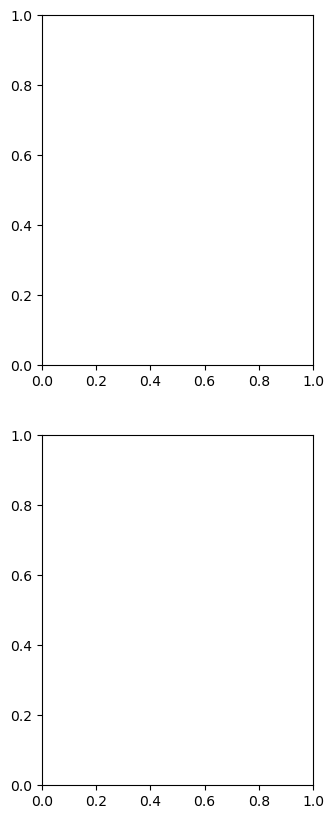

In [ ]:
# Create the analyzer for the experiments
ber_r = (np.min(ber_range), np.max(ber_range))
protection_r = (np.min(protection_range), np.max(protection_range))
metrics = InjectionPerformanceMetrics.from_range(protection_range = protection_r, ber_range = ber_r, granularity = [0.05, 5e-3])
for exp in exps:
    metrics.add_experiment(exps[exp]['qpolargrad'], name = exp)
doc.append(metrics.html())
doc.save(filename)

In [ ]:
filename

/tmp/ipykernel_2840531/221024337.py:286: UserWarning: The following kwargs were not used by contour: 'linewidth', 'hatch_alpha', 'zlevel', 'edgecolor', 'hatch_linewidth'
  hcs = axs[im][1].contourf(xgrid, ygrid, mask_right,


Optimal point of protection: 0.35000000000000003 for area
Optimal point of protection: 0.7000000000000001 for power


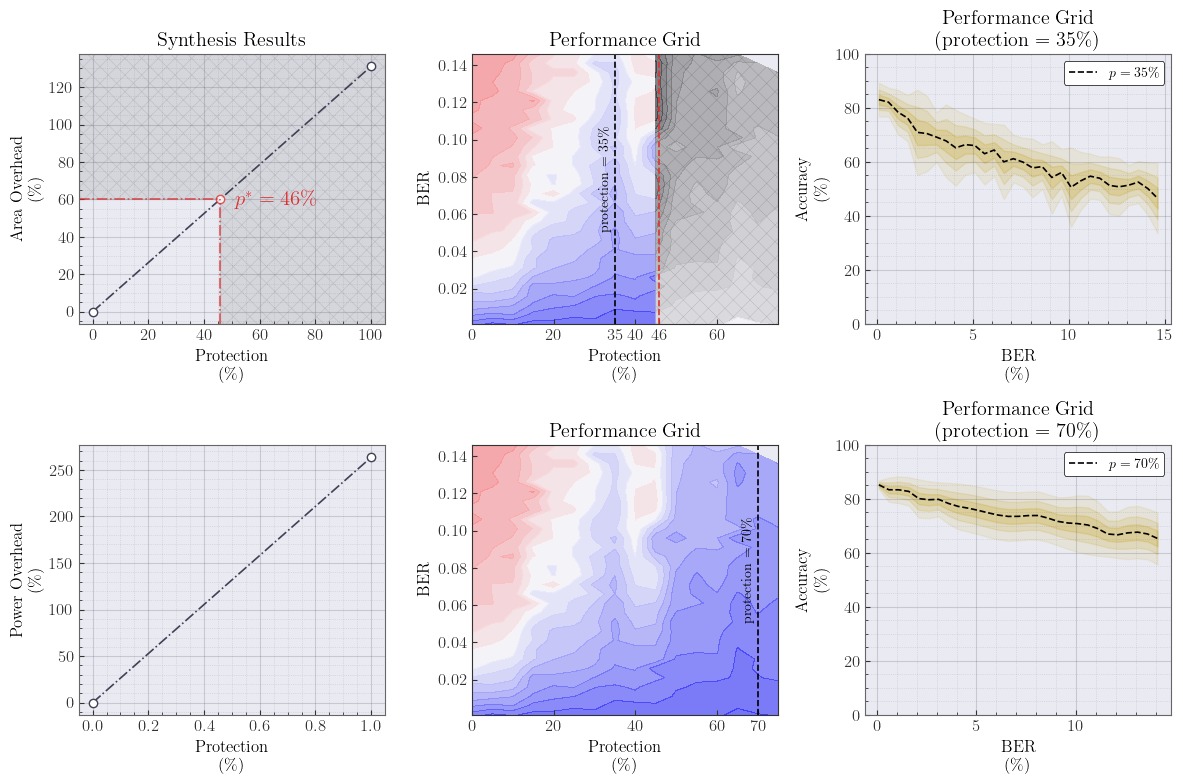

/tmp/ipykernel_2840531/221024337.py:286: UserWarning: The following kwargs were not used by contour: 'linewidth', 'hatch_alpha', 'zlevel', 'edgecolor', 'hatch_linewidth'
  hcs = axs[im][1].contourf(xgrid, ygrid, mask_right,


Optimal point of protection: 0.0 for area
Optimal point of protection: 0.0 for power


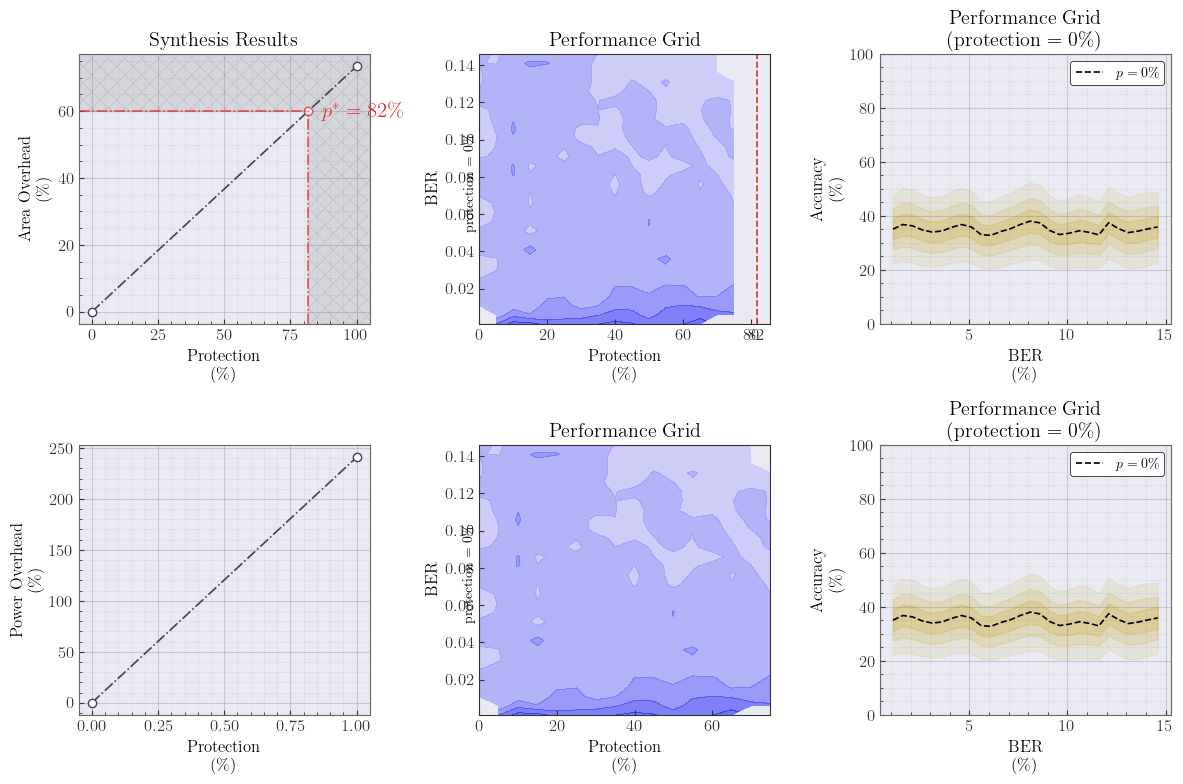

        │ 16:15:50.46 │ - ymax 0.6 is out of bounds. Skipping plot.


Optimal point of protection: 0.0 for area
Optimal point of protection: 0.0 for power


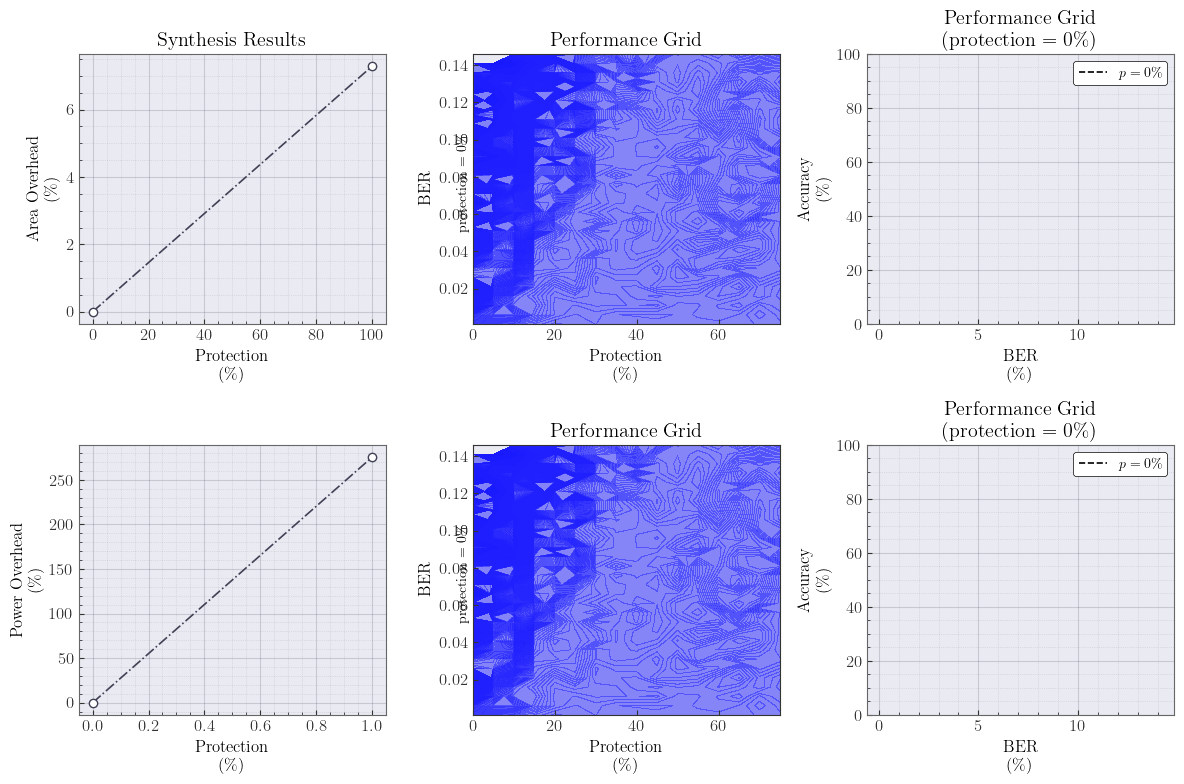

In [ ]:
import matplotlib.patches as mpatches
import matplotlib as mpl

from matplotlib.colors import LinearSegmentedColormap


# Enable LaTeX rendering and Seaborn‑like style
plt.rcParams.update({
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 12,
    'axes.facecolor': '#EAEAF2',
    'figure.facecolor': 'white',
    'axes.edgecolor': '#333333',
    'axes.linewidth': 0.8,
    'xtick.color': '#333333',
    'ytick.color': '#333333',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'legend.frameon': False,
})

LINECOLOR = '#404155'
SPINECOLOR = '#666666'
OPTLINECOLOR = '#dc3131'
OPTSHADECOLOR = '#252121'
BESTLINECOLOR = '#000000'
STDFILLCOLOR = '#c2a110'

# define your own red→yellow→green map
CUSTOMCMAP = LinearSegmentedColormap.from_list(
    'good_bad',
    ['#d7191c',  # red (bad)
     '#f4f438',  # yellow (mid)
     '#0586c1']  # #0586c1 (good)
)

def grids_on(ax):
    """
    Add grids to the given axes.
    """
    ax.minorticks_on()
    ax.grid(which='major', color=LINECOLOR, linestyle='-', linewidth=0.8, alpha=0.2)
    ax.grid(which='minor', color=LINECOLOR, linestyle=':', linewidth=0.5, alpha=0.2)
    for spine in ax.spines.values():
        spine.set_color(SPINECOLOR)

# Define the area boundaries (this comes from hls + genus synthesis)
@dataclass
class SynthesisResult:
    """
    Class to hold synthesis results for a given experiment and metric.
    """
    name: str
    area: List[float]
    timing: List[float]
    power: List[float]
    # Protection is optional, default value (0.0, 1.0)
    protection: Optional[List[float]] = field(default_factory=lambda: [0.0, 1.0])
    # Normalize (to compute overhead) is optional, default value (False)
    normalize: Optional[bool] = field(default_factory=lambda: False)

    # Initalize a couple of handy props
    area_label = 'Area\n$\mathrm{(\mu{m}}^2)$' if not normalize else 'Area Overhead\n$\mathrm{(\%)}$'
    timing_label = 'Timing\n$(\\mathrm{ns})$'  if not normalize else 'Timing Overhead\n$\mathrm{(\%)}$'
    power_label = 'Power\n$\mathrm{(nW)}$' if not normalize else 'Power Overhead\n$\mathrm{(\%)}$'

    def __post_init__(self):
        if self.normalize:
            # Normalize the area, timing and power values
            self.area = [(a - self.area[0]) / self.area[0] for a in self.area] if np.all([a is not None for a in self.area]) else [None, None]
            self.timing = [(t - self.timing[0]) / self.timing[0] for t in self.timing] if np.all([t is not None for t in self.timing]) else [None, None]
            self.power = [(p - self.power[0]) / self.power[0] for p in self.power] if np.all([p is not None for p in self.power]) else [None, None]

    @staticmethod
    def _plot_stat(ax, x, y, label, xlabel = None, ylabel = None, title = None, color = LINECOLOR, ymax = None):
        """
        Helper function to plot a single statistic.
        """
        ax.plot(x, y, 
                label = label, 
                color = color, 
                linestyle='-.',    # solid line
                marker='o',       # circle marker
                linewidth=1.2,
                markersize=6,
                markerfacecolor='white',
                markeredgewidth=1)
        

        # if ymax is not None, we will plot it, as well as the lines to the point (horizontal and vertical)
        # and then we will have anything over these points as a shaded area, representing that this is out
        # of the area of interest
        pstar = (None, None)
        if ymax is not None and y is not None and x is not None:

            yrange = np.max(y) - np.min(y) if y is not None else 0
            xrange = np.max(x) - np.min(x) if x is not None else 0
            
            # Make sure we are within boundaries
            if ymax > y[0] and ymax < y[-1]:
                # Fit a linear function to the data
                if len(x) > 2:
                    popt, _ = curve_fit(lambda x, a, b: a*x + b, x, y)
                else:
                    # If we have only two points, we can use them to get the slope
                    popt = np.polyfit(x, y, 1)
               
                # Now we want to find the equivalent x value for "ymax", given popt
                xmax = (ymax - popt[1])/popt[0]

                # Make sure we are within the x boundaries
                if xmax > x[0] and xmax < x[-1]:
                
                    # Plot the point
                    ax.plot(xmax, ymax,
                            color = OPTLINECOLOR, 
                            linestyle='--',    # solid line
                            marker='o',       # circle marker
                            linewidth=1.2,
                            markersize=6,
                            markerfacecolor='white',
                            markeredgewidth=1,
                            alpha = 0.8)
                    # Add a text right next to the point with the label "p*"
                    ax.text(xmax + 0.05, ymax, r'$p^{*}=' + f'{xmax*100:.0f}' + r'\%$', fontsize=15, color = OPTLINECOLOR,
                            ha = 'left', va = 'center')

                    # Get the x and y limits
                    xlim = ax.get_xlim()
                    ylim = ax.get_ylim()
                    # Plot the lines to the point
                    ax.plot([xlim[0], xmax], [ymax, ymax], '-.', linewidth=1.2, color = OPTLINECOLOR, alpha = 0.8)
                    ax.plot([xmax, xmax], [ylim[0], ymax], '-.', linewidth=1.2, color = OPTLINECOLOR, alpha = 0.8)
                    # Shade the area over the point
                    # 2) define the polygon vertices (clockwise or ccw)
                    verts = [
                        (xmax, ylim[0]),   # start at bottom of the vertical strip
                        (xlim[1], ylim[0]), # bottom‑right
                        (xlim[1], ylim[1]), # top‑right
                        (xlim[0], ylim[1]), # top‑left
                        (xlim[0], ymax),   # left of the horizontal strip
                        (xmax, ymax),     # the corner at (xp, yp)
                    ]

                    pstar = (xmax, ymax)

                    # 3) add a single patch
                    poly = mpatches.Polygon(
                        verts,
                        closed=True,
                        facecolor=OPTSHADECOLOR,
                        alpha=0.1,
                        edgecolor=(0,0,0,0.3),
                        hatch='xx',         # diagonal hatches
                        hatch_linewidth=.5,            # per‐patch hatch thickness
                    )
                    ax.add_patch(poly)

                    # Make sure to reset the limits (they will be changed after we use them to plot the lines to the point)
                    ax.set_xlim(xlim)
                    ax.set_ylim(ylim)
            else:
                netsurf.warn(f"ymax {ymax} is out of bounds. Skipping plot.")
        
        if xlabel is not None:
            lbl = ax.set_xlabel(xlabel)
            lbl.set_multialignment('center')
        else:
            ax.set_xticklabels('')
        if ylabel is not None:
            lbl = ax.set_ylabel(ylabel)
            lbl.set_multialignment('center')
        else:
            ax.set_yticklabels('')
        if title is not None:
            ax.set_title(title)
        # Grids on 
        grids_on(ax)

        return pstar

        

    # plot stats vs protection
    def plot(self, max_stat = None, metrics = ['area', 'timing', 'power'], performance_grid = None, levels = 10, cmap = CUSTOMCMAP):

        # Make sure metrics are valid
        if not isinstance(metrics, list):
            metrics = [metrics]
        for metric in metrics:
            if metric not in ['area', 'timing', 'power']:
                raise ValueError(f"Invalid metric: {metric}. Must be one of ['area', 'timing', 'power']")
        
    
        ncols = 1 if not performance_grid else 3
        nrows = len(metrics)

        fig, axs = plt.subplots(nrows, ncols, figsize = (4*ncols, 4*nrows))
        
        if max_stat is not None:
            # Make sure the max_stat is a dict with keys 'area', 'timing', 'power'
            if not isinstance(max_stat, dict):
                max_stat = None
            else:
                if 'area' not in max_stat:
                    max_stat['area'] = None
                if 'timing' not in max_stat:
                    max_stat['timing'] = None
                if 'power' not in max_stat:
                    max_stat['power'] = None
        
        if max_stat is None:
            max_stat = {'area': None, 'timing': None, 'power': None}

        # Percent formatter
        formatter = FuncFormatter(lambda x, _: f"{x:3.0%}")

        # Plot area
        k = 0
        pstar = {m: (None,None) for m in metrics}
        if 'area' in metrics:
            pstar['area'] = SynthesisResult._plot_stat(axs[k][0], self.protection, self.area, 
                                    label = self.name, 
                                    ylabel = self.area_label,
                                    title = 'Synthesis Results',
                                    xlabel = 'Protection\n$\mathrm{(\%)}$',
                                    ymax = max_stat['area'])
            if self.normalize:
                axs[k][0].yaxis.set_major_formatter(formatter) if 'area' in metrics else None
            # Set xlabels formatter as percentages
            axs[k][0].xaxis.set_major_formatter(formatter)

            k += 1
            
        # Plot timing
        if 'timing' in metrics:
            pstar['timing'] = SynthesisResult._plot_stat(axs[k][0], self.protection, self.timing,
                                        label = self.name, 
                                        ylabel = self.timing_label,
                                        xlabel = 'Protection\n$\mathrm{(\%)}$',
                                        ymax = max_stat['timing'])
            if self.normalize:
                axs[k][0].yaxis.set_major_formatter(formatter) if 'timing' in metrics else None
            # Set xlabels formatter as percentages
            axs[k][0].xaxis.set_major_formatter(formatter)

            k += 1
        
        # Plot power
        if 'power' in metrics:
            pstar['power'] = SynthesisResult._plot_stat(axs[k][0], self.protection, self.power,
                                        label = self.name, 
                                        ylabel = self.power_label,
                                        xlabel = 'Protection\n$\mathrm{(\%)}$',
                                        ymax = max_stat['power'])
            if self.normalize:
                axs[k][0].yaxis.set_major_formatter(formatter) if 'power' in metrics else None
            k += 1

        
        old_linewidth = plt.rcParams['hatch.linewidth']
        plt.rcParams['hatch.linewidth'] = 0.1
        # Plot performance grid now mean as a contour 
        if performance_grid is not None:
            for im, m in enumerate(metrics):
                xgrid, ygrid, zgrid, stdgrid = performance_grid

                # Plot the performance grid
                p0 = pstar[m][0]
                xlims = None
                if p0 is not None:
                    
                    # 2) mask RIGHT-of-p0 for the Viridis patch (we only want x <= p0 here)
                    mask_left = np.ma.masked_where(xgrid > p0, zgrid)
                    cf_left = axs[im][1].contourf(
                        xgrid, ygrid, mask_left,
                        levels=levels,
                        cmap=cmap,
                        extend='both',
                        alpha = 0.5
                    )
                    
                    # 6) Add a hatch on exactly the same masked region
                    mask_right = np.ma.masked_where(xgrid < p0 - (xgrid[0][1] + xgrid[0][0])/2, zgrid)
                    hcs = axs[im][1].contourf(xgrid, ygrid, mask_right,
                                levels=levels,
                                colors='none',          # no fill
                                linewidth=0,
                                hatch_alpha = 0.3,
                                zlevel = 10,
                                edgecolor=(0,0,0,0.3),
                                hatches=['xx'],         # diagonal hatches
                                hatch_linewidth=.5,            # per‐patch hatch thickness)
                    )
                    
                    # 5) Overlay a gray‐scale contour on that right region
                    # 4) mask LEFT-of-p0 for the gray patch (we only want x > p0 here)
                    
                    cf_right = axs[im][1].contourf(
                        xgrid, ygrid, mask_right,
                        levels=levels,
                        cmap='Greys_r',
                        alpha=0.5,
                        norm = mpl.colors.Normalize(vmin=np.nanmin(mask_right), vmax=1.2*np.nanmax(mask_right)),
                        extend='both'
                    )

                    # Vertical line at pstar
                    axs[im][1].axvline(p0, color=OPTLINECOLOR, linestyle='--', linewidth=1.2)
                    # Add a text label as if it was a ticklabel
                    # Get xlims first
                    xlims = axs[im][1].get_xlim()
                    # place text at (x = p0, y = –0.05) in (data, axis) coords
                    # 1) grab current ticks
                    orig_ticks = list(axs[im][1].get_xticks())

                    # 2) insert p0 and sort+unique
                    all_ticks = sorted(set(orig_ticks + [p0]))

                    # 3) re‑apply ticks
                    axs[im][1].set_xticks(all_ticks)

                    # 4) build matching labels
                    new_labels = []
                    for t in all_ticks:
                        if np.isclose(t, p0):
                            new_labels.append(f'{p0*100:.0f}\\%')   # format p0 as “46%”, say
                        else:
                            new_labels.append(f'{t*100:.0f}\\%')    # or use your existing style

                    axs[im][1].set_xticklabels(new_labels)
                    
                    # Reset xlims 
                    axs[im][1].set_xlim(xlims)


                    
                else:
                    mask_left = np.ma.masked_where(xgrid < 0, zgrid)

                    axs[im][1].contourf(xgrid, ygrid, zgrid, levels=levels, cmap=cmap, extend='both', alpha = 0.5)


                # Find the optimal point of protection (xopt) for which the vertical sum of the grid is maximum 
                # (max acc over all BER), HOWEVER, inside the p0 region
                xopt = np.argmax(np.sum(mask_left, axis=0))
                print(f"Optimal point of protection: {xgrid[0][xopt]} for {m}")
                # Plot a vertical line at xopt
                axs[im][1].axvline(xgrid[0][xopt], color=BESTLINECOLOR, linestyle='--', linewidth=1.2)

                # Add a text label rotated 90degrees to the left, sitting on the line
                axs[im][1].text(xgrid[0][xopt] - 0.01, 0.05, f'protection = {xgrid[0][xopt]*100:.0f}\\%', fontsize=10, color=BESTLINECOLOR,
                            ha='right', va='bottom', rotation=90)


                # Store xlims first
                xlims = axs[im][1].get_xlim()

                # # 1) grab current ticks
                orig_ticks = list(axs[im][1].get_xticks())

                # 2) insert p0 and sort+unique
                all_ticks = sorted(set(orig_ticks + [xgrid[0][xopt]]))

                # 3) re‑apply ticks
                axs[im][1].set_xticks(all_ticks)

                # 4) build matching labels
                new_labels = []
                for t in all_ticks:
                    if np.isclose(t, xgrid[0][xopt]):
                        new_labels.append(f'{xgrid[0][xopt]*100:.0f}\\%')   # format p0 as “46%”, say
                    else:
                        new_labels.append(f'{t*100:.0f}\\%')    # or use your existing style

                axs[im][1].set_xticklabels(new_labels)

                # Reset xlims
                axs[im][1].set_xlim(xlims)
                



                axs[im][1].set_title('Performance Grid')
                axs[im][1].set_xlabel('Protection\n$\mathrm{(\%)}$')
                axs[im][1].set_ylabel('BER')
                axs[im][1].set_aspect('auto')
                # Set xlabels formatter as percentages
                axs[im][1].xaxis.set_major_formatter(formatter)

                # In axs[im][2] plot the line for all z, for the given xopt (for all y)
                # Get the y values for the given xopt
                yopt = ygrid[:, xopt]
                # Get the z values for the given xopt
                zopt = zgrid[:, xopt]
                # get the std values for the given xopt
                stdopt = stdgrid[:, xopt]
                # Plot the line
                axs[im][2].plot(yopt, zopt, color=BESTLINECOLOR, linestyle='--', linewidth=1.2, label = r'$p=' + f'{xgrid[0][xopt]*100:.0f}' + r'\%$')
                # Fill between +- std
                #if cmap is not string, color of the fill will be the cmap for the average value of zgrid across this line
                axs[im][2].fill_between(yopt, zopt - .3*stdopt, zopt + .3*stdopt, color=STDFILLCOLOR, alpha=0.2)
                axs[im][2].fill_between(yopt, zopt - .6*stdopt, zopt + .6*stdopt, color=STDFILLCOLOR, alpha=0.15)
                axs[im][2].fill_between(yopt, zopt - stdopt, zopt + stdopt, color=STDFILLCOLOR, alpha=0.10)

                lbl = axs[im][2].set_title('Performance Grid\n(protection = ' + f'{xgrid[0][xopt]*100:.0f}' + r'\%)')
                lbl.set_multialignment('center')
                # add legend
                leg = axs[im][2].legend(loc='upper right',fontsize=10, frameon=True, framealpha=1.0)
                frame = leg.get_frame()
                frame.set_color('white')
                frame.set_edgecolor('black')
                frame.set_linewidth(0.5)
                # grids on
                grids_on(axs[im][2])
                # X label now is BER
                lbl = axs[im][2].set_xlabel('BER\n$\mathrm{(\%)}$')
                lbl.set_multialignment('center')
                # Y label is the metric (accuracy)
                lbl = axs[im][2].set_ylabel('Accuracy\n$\mathrm{(\%)}$')
                lbl.set_multialignment('center')
                # Set xlabels formatter as percentages
                axs[im][2].xaxis.set_major_formatter(formatter)
                # Set ylabels formatter as percentages
                axs[im][2].yaxis.set_major_formatter(formatter)
                # set ylim to 0,1
                axs[im][2].set_ylim(0, 1)


        plt.tight_layout()

        plt.show()

        # Set back 
        plt.rcParams['hatch.linewidth'] = old_linewidth

        return pstar


# Add results 
res = {}
mets = {'mnist_fnn_lite': 'categorical_accuracy', 'smartpixel_large': 'categorical_accuracy', 
        'tinyml_anomaly_detection': 'mean_squared_error'}
res['mnist_fnn_lite'] = SynthesisResult(name = 'mnist_fnn_lite', area = [1515687.94, 3503353.221], 
                    timing = [None, None], power = [8.8, 32], 
                    protection = [0.0, 1.0],
                    normalize = True)

res['smartpixel_large'] = SynthesisResult(name = 'smartpixel_large', area = [729543.613, 1265313.561], 
                    timing = [-985.8, -0.2], power = [32.4772, 110.711], 
                    protection = [0.0, 1.0],
                    normalize = True)

res['tinyml_anomaly_detection'] = SynthesisResult(name = 'smartpixel_large', area = [1716445.676, 1841554.616], 
                    timing = [-6937.6, -530.2], power = [229.2313529, 860.634], 
                    protection = [0.0, 1.0],
                    normalize = True)



# 6. Fill NaN values using griddata interpolation
for rname, r in res.items():
    xgrid, ygrid = np.meshgrid(metrics.protection_edges[:-1], metrics.ber_edges[:-1])
    zgrid = metrics.moment_grids[rname][mets[rname]]['mean']
    stdgrid = metrics.moment_grids[rname][mets[rname]]['std']
    dacc = 0.05
    levels = np.arange(0.0, (1.0+dacc)*np.nanmax(zgrid), dacc)

    pstar = r.plot(max_stat = {'area': 0.6, 'power': 0.7}, metrics = ['area', 'power'], 
        performance_grid = (xgrid, ygrid, zgrid, stdgrid), levels = levels,
        cmap = 'bwr_r')


In [ ]:
# Plot 3d scatter 
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(exps[exp].results['protection'], exps[exp].results['ber'], exps[exp].results['categorical_accuracy'], c=exps[exp].results['categorical_accuracy'], cmap='viridis', marker='o')
ax.set_xlabel('Protection')
ax.set_ylabel('BER')
ax.set_zlabel('Categorical Accuracy')
ax.set_title('3D Scatter Plot of Categorical Accuracy')
# rotate
ax.view_init(elev=20, azim=120)
plt.show()

In [ ]:
qqmodel = bmk.model
qqmodel.summary()

In [ ]:
# Let's now translate the model into a simple qkeras model for compilation
import qkeras
import tensorflow as tf

# Get the quantization scheme 
Q = qqmodel.quantizer
print(Q)
q_scheme = f'quantized_bits({Q.m},{Q.n},{bool(Q.s)}, alpha = 1, use_variables = True)'
q_relu = f'quantized_relu({Q.m},{Q.n},{bool(Q.s)}, use_variables = True)'
q_precision = f'ac_fixed<{Q.m},{Q.n+Q.s},{bool(Q.s)}>'
n2 = Q.n*2
f2 = Q.f*2
m2 = n2 + f2 + int(Q.s)
double_q_precision = f'ac_fixed<{m2},{n2+Q.s},{bool(Q.s)}>'

print(q_scheme)


In [ ]:
inputs = None 
for ilayer, layer in enumerate(qqmodel.layers):
    print(layer.name)
    name = layer.name.replace('qq_', '')
    if isinstance(layer, tf.keras.layers.InputLayer):
        x = tf.keras.layers.Input(shape = layer.input_shape[0][1:], name = 'in0')
        if inputs is None:
            inputs = [x]
        elif isinstance(inputs, list):
            inputs.append(x)

    elif isinstance(layer, tf.keras.layers.Flatten):
        x = tf.keras.layers.Flatten(name = name)(x)
    
    elif isinstance(layer, tf.keras.layers.Dense):
        ly = qkeras.QDense(layer.units, kernel_quantizer = q_scheme, name = name)
        
        # Pass the tensor so we can build the layer 
        x = ly(x)

        # The next one MUST be a qqapplyalpha
        next_layer = qqmodel.layers[ilayer + 1]
        if isinstance(next_layer, netsurf.dnn.layers.QQApplyAlpha):
            
            # Transfer the weights over
            # Remember we will have to apply the QAlpha to the dense layer before it
            ws_fc0 = {v.name.split('/')[1].split(':')[0]: v for v in ly.trainable_variables}
            ws_alpha0 = {v.name.split('/')[1].split(':')[0]: v for v in next_layer.trainable_variables}

            # merge fc0 and alpha0
            ws_fc0_alpha0 = {'kernel': ws_fc0['kernel']*ws_alpha0['alpha'], 'bias': ws_fc0['bias']*ws_alpha0['alpha'] + ws_alpha0['beta']}
            ly.kernel.assign(ws_fc0_alpha0['kernel'])
            ly.bias.assign(ws_fc0_alpha0['bias'])
        elif isinstance(next_layer, tf.keras.layers.Softmax) or isinstance(next_layer, tf.keras.layers.Activation) or isinstance(next_layer, netsurf.dnn.layers.QQSoftmax) or isinstance(next_layer, netsurf.dnn.layers.QQActivation):
            # It's okay
            continue
        else:
            raise ValueError(f"Layer {layer.name} should be followed by a QQApplyAlpha layer, but got {next_layer.name} instead")

    
    elif isinstance(layer, tf.keras.layers.Conv2D):
        ly = qkeras.QConv2D(layer.filters, kernel_size = layer.kernel_size, strides = layer.strides,
                        padding = layer.padding, kernel_quantizer = q_scheme, name = name)
        
        # Pass the tensor so we can build the layer 
        x = ly(x)

        # The next one MUST be a qqapplyalpha
        next_layer = qqmodel.layers[ilayer + 1]
        if isinstance(next_layer, netsurf.dnn.layers.QQApplyAlpha):
            
            # Transfer the weights over
            # Remember we will have to apply the QAlpha to the dense layer before it
            ws_fc0 = {v.name.split('/')[1].split(':')[0]: v for v in ly.trainable_variables}
            ws_alpha0 = {v.name.split('/')[1].split(':')[0]: v for v in next_layer.trainable_variables}

            # merge fc0 and alpha0
            ws_fc0_alpha0 = {'kernel': ws_fc0['kernel']*ws_alpha0['alpha'], 'bias': ws_fc0['bias']*ws_alpha0['alpha'] + ws_alpha0['beta']}
            ly.kernel.assign(ws_fc0_alpha0['kernel'])
            ly.bias.assign(ws_fc0_alpha0['bias'])
        
        elif isinstance(next_layer, tf.keras.layers.Softmax) or isinstance(next_layer, tf.keras.layers.Activation) or isinstance(next_layer, netsurf.dnn.layers.QQSoftmax) or isinstance(next_layer, netsurf.dnn.layers.QQActivation):
            # It's okay
            continue
        else:
            raise ValueError(f"Layer {layer.name} should be followed by a QQApplyAlpha layer, but got {next_layer.name} instead")

    elif isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        ly = qkeras.QDepthwiseConv2D(kernel_size = layer.kernel_size, strides = layer.strides,
                                    padding = layer.padding, depth_multiplier = 1, depthwise_quantizer = q_scheme, bias_quantizer = q_scheme, name = name,
                                    data_format = layer.data_format)
        
        # Pass the tensor so we can build the layer 
        x = ly(x)

        # The next one MUST be a qqapplyalpha
        next_layer = qqmodel.layers[ilayer + 1]
        if isinstance(next_layer, netsurf.dnn.layers.QQApplyAlpha):
            
            # Transfer the weights over
            # Remember we will have to apply the QAlpha to the dense layer before it
            ws_fc0 = {v.name.split('/')[1].split(':')[0]: v for v in ly.trainable_variables}
            ws_alpha0 = {v.name.split('/')[1].split(':')[0]: v for v in next_layer.trainable_variables}

            # merge fc0 and alpha0
            ws_fc0_alpha0 = {'kernel': ws_fc0['depthwise_kernel']*(ws_alpha0['alpha'][:,None]), 'bias': ws_fc0['bias']*ws_alpha0['alpha'] + ws_alpha0['beta']}
            ly.depthwise_kernel.assign(ws_fc0_alpha0['kernel'])
            ly.bias.assign(ws_fc0_alpha0['bias'])
        
        elif isinstance(next_layer, tf.keras.layers.Softmax) or isinstance(next_layer, tf.keras.layers.Activation) or isinstance(next_layer, netsurf.dnn.layers.QQSoftmax) or isinstance(next_layer, netsurf.dnn.layers.QQActivation):
            # It's okay
            continue
        else:
            raise ValueError(f"Layer {layer.name} should be followed by a QQApplyAlpha layer, but got {next_layer.name} instead")


    elif isinstance(layer, tf.keras.layers.MaxPooling2D):
        x = tf.keras.layers.MaxPooling2D(pool_size = layer.pool_size, strides = layer.strides,
                                        padding = layer.padding, name = name)(x)
    
    elif isinstance(layer, tf.keras.layers.AveragePooling2D):
        x = tf.keras.layers.AveragePooling2D(pool_size = layer.pool_size, strides = layer.strides,
                                        padding = layer.padding, name = name)(x)
    
    elif isinstance(layer, tf.keras.layers.Activation) or isinstance(layer, netsurf.dnn.layers.QQActivation):
        x = qkeras.QActivation(layer.activation, name = name)(x)
    
    elif isinstance(layer, tf.keras.layers.Dropout):
        x = tf.keras.layers.Dropout(layer.rate, name = name)(x)
    
    elif isinstance(layer, tf.keras.layers.BatchNormalization):
        ly = tf.keras.layers.BatchNormalization(name = name)
        # Pass 
        x = ly(x)
        # We need to pass over the weights
        # Transfer the weights over
        # Remember we will have to apply the QAlpha to the dense layer before it
        ws_fc0 = {v.name.split('/')[1].split(':')[0].replace('qq_',''): v for v in layer.trainable_variables}
        # Add moving_variance and moving_average
        ws_fc0['moving_mean'] = layer.moving_mean
        ws_fc0['moving_variance'] = layer.moving_variance

        # merge fc0 and alpha0
        for key in ws_fc0.keys():
            if 'gamma' in key:
                print(f'Assigning layer.gamma to {key}')
                ly.gamma.assign(ws_fc0[key])
            elif 'beta' in key:
                print(f'Assigning layer.beta to {key}')
                ly.beta.assign(ws_fc0[key])
            elif 'moving_mean' in key:
                print(f'Assigning layer.moving_mean to {key}')
                ly.moving_mean.assign(ws_fc0[key])
            elif 'moving_variance' in key:
                print(f'Assigning layer.moving_variance to {key}')
                ly.moving_variance.assign(ws_fc0[key])
            else:
                raise ValueError(f"Unknown key {key} in BatchNormalization layer {layer.name}")

    
    elif isinstance(layer, tf.keras.layers.Softmax):
        x = tf.keras.layers.Softmax(name = name)(x)
    else:
        if not isinstance(layer, netsurf.dnn.layers.QQApplyAlpha):
            print(f"Layer {name} not supported, skipping...")
        continue

# Build model
model = tf.keras.models.Model(inputs=inputs, outputs=x)
model.summary()

In [ ]:
# # Loop thru weights to check their values 
# import matplotlib.pyplot as plt 
# for v in model.trainable_variables:
#     plt.hist(v.numpy().flatten(), bins=100)
#     plt.title(v.name)
#     plt.show()

In [ ]:
benchmarks_dir = os.path.join(parent_dir, 'benchmarks')
datasets_dir = os.path.join(parent_dir, 'datasets')

In [ ]:
# Loop thru layers and print the number of parameters per layer 
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.InputLayer):
        continue
    print(f'{layer.name}: {layer.count_params()}') if layer.count_params() > 0 else None
    #print(layer.input_shape)
    #print(layer.output_shape)

In [ ]:
# Then the QKeras model
import hls4ml

outpath = os.path.join(bmk.models_dir,'syn')
os.makedirs(outpath, exist_ok = True)

# Convert model to hls4ml
hls_config_q = hls4ml.utils.config_from_keras_model(model, granularity='name')
hls_config_q['Model']['ReuseFactor'] = 2000
hls_config_q['Model']['Precision'] = q_precision
hls_config_q["Model"]["Strategy"] = "Resource"
hls_config_q["Model"]["BramFactor"] = 0

"""
    Input
"""
hls_config_q['LayerName']['in0']['Precision']['result'] = 'ac_fixed<8,1>'


# Loop thru layers and assign precision
for ly in model.layers:
    # Get name 
    name = ly.name 
    if isinstance(ly, tf.keras.layers.Dense) or isinstance(ly, qkeras.QDense) or isinstance(ly, tf.keras.layers.Conv2D) or isinstance(ly, qkeras.QConv2D):
        hls_config_q['LayerName'][name]['Precision']['weight'] = q_precision
        hls_config_q['LayerName'][name]['Precision']['bias'] = q_precision
        hls_config_q['LayerName'][name]['Precision']['result'] = double_q_precision
        hls_config_q['LayerName'][name]['ReuseFactor'] = 2000
    
    elif isinstance(ly, tf.keras.layers.DepthwiseConv2D) or isinstance(ly, qkeras.QDepthwiseConv2D):
        hls_config_q['LayerName'][name]['Precision']['weight'] = q_precision
        hls_config_q['LayerName'][name]['Precision']['bias'] = q_precision
        hls_config_q['LayerName'][name]['Precision']['result'] = double_q_precision
        hls_config_q['LayerName'][name]['ReuseFactor'] = 2000
        hls_config_q['LayerName'][name]['min_height'] = 3
        hls_config_q['LayerName'][name]['min_width'] = 3
        hls_config_q['LayerName'][name]['instructions'] = 1
        #min_height
        
    
    elif isinstance(ly, tf.keras.layers.BatchNormalization):
        hls_config_q['LayerName'][name]['Precision']['scale'] = q_precision
        hls_config_q['LayerName'][name]['Precision']['bias'] = q_precision
        hls_config_q['LayerName'][name]['Precision']['result'] = double_q_precision
        hls_config_q['LayerName'][name]['Precision']['mean'] = q_precision
        hls_config_q['LayerName'][name]['Precision']['variance'] = q_precision
        hls_config_q['LayerName'][name]['Precision']['moving_variance'] = q_precision
        hls_config_q['LayerName'][name]['Precision']['moving_mean'] = q_precision
    
    elif isinstance(ly, tf.keras.layers.Softmax):
        hls_config_q['LayerName'][name]['Strategy'] = 'Stable'
        hls_config_q['LayerName'][name]['Precision'] = f'ac_fixed<{Q.m},0,false>'
        hls_config_q['LayerName'][name]['exp_table_t'] = 'ac_fixed<4,0>'
        hls_config_q['LayerName'][name]['inv_table_t'] = 'ac_fixed<4,0>'
    
    else:
        if name in hls_config_q['LayerName']:
            # Just set the precision to be q_precision for the result 
            hls_config_q['LayerName'][name]['Precision']['result'] = q_precision
        else:
            print(f'Layer {name} not found in hls_config_q. Skipping')









# """
#     fc0
# """
# # Weights & bias 
# hls_config_q['LayerName']['fc0']['Precision']['weight'] = 'ac_fixed<8,0,true>'
# # Set bias precision
# hls_config_q['LayerName']['fc0']['Precision']['bias'] = q_precision
# # Set activation precision
# hls_config_q['LayerName']['fc0']['Precision']['result'] = double_q_precision
# hls_config_q['LayerName']['fc0']['FlattenWeights'] = True
# hls_config_q['LayerName']['fc0']['ReuseFactor'] = 2000

# """
#     fcout
# """
# # Weights & bias 
# hls_config_q['LayerName']['fc_out']['Precision']['weight'] = q_precision
# # Set bias precision
# hls_config_q['LayerName']['fc_out']['Precision']['bias'] = q_precision
# # Set activation precision
# hls_config_q['LayerName']['fc_out']['Precision']['result'] = double_q_precision
# hls_config_q['LayerName']['fc_out']['ReuseFactor'] = 640


# # fcout
# hls_config_q['LayerName']['fc_out']['Precision']['result'] = "ac_fixed<8,1,false>"

# """ 
#     softmax
# """
# hls_config_q['LayerName']['softmax']['Strategy'] = 'Stable'
# hls_config_q['LayerName']['softmax']['Precision'] = f'ac_fixed<{Q.m},0,false>'
# hls_config_q['LayerName']['softmax']['exp_table_t'] = 'ac_fixed<4,0>'
# hls_config_q['LayerName']['softmax']['inv_table_t'] = 'ac_fixed<4,0>'

import json 
print(json.dumps(hls_config_q, indent=4))


In [ ]:

""" Create catapult config """
cfg_q = hls4ml.converters.create_config(backend='catapult')
cfg_q['IOType'] = 'io_stream'  # Must set this if using CNNs!
cfg_q['HLSConfig'] = hls_config_q
cfg_q['KerasModel'] = model
cfg_q['OutputDir'] = outpath
#cfg_q['Technology'] = 'fpga' # inportant, should be in lower case
cfg_q['Technology'] = 'asic' # inportant, should be in lower case
cfg_q['ClockPeriod'] = 10
cfg_q['ASICLibs'] = 'nangate-45nm_beh'
cfg_q['FIFO'] = 'hls4ml_lib.mgc_pipe_mem'
cfg_q['ASICFIFO']='hls4ml_lib.mgc_pipe_mem'
#cfg_q['XilinxPart'] = 'xczu7cg-fbvb900-1-e'
#cfg_q['Part'] = 'xczu7cg-fbvb900-1-e'
#cfg_q.pop['XilinxPart']


# cfg_q['BuildOptions'] = {
#             'csim': True,
#             'SCVerify': True,
#             'Synth': True,
#             'vhdl': False,
#             'verilog': True,
#             'RTLSynth': False,
#             'RandomTBFrames': 2,
#             'PowerEst': False,
#             'PowerOpt': False,
#             'BuildBUP': False,
#             'BUPWorkers': False,
#             'LaunchDA': False,
#         }

print(cfg_q)

hls_model_q = hls4ml.converters.keras_to_hls(cfg_q)
hls_model_q.compile()

In [ ]:
# Loop thru layers and print the number of parameters per layer 
import numpy as np
ws = {}
for il, layer in enumerate(model.layers):
    if isinstance(layer, tf.keras.layers.InputLayer):
        continue
    if layer.name.startswith('fc') or layer.name.startswith('dense'):
        wc = int(np.prod(layer.kernel.shape))
        bc = int(np.prod(layer.bias.shape))
        ws[f'w{il}'] = [int(wc*6), wc]
        ws[f'b{il}'] = [int(bc*6), bc]
    elif layer.name.startswith('bn'):
        wc = int(np.prod(layer.gamma.shape))
        bc = int(np.prod(layer.beta.shape))
        ws[f's{il}'] = [int(wc*6), bc]
        ws[f'b{il}'] = [int(bc*6), bc]
print(ws)

In [ ]:
# Code to generate the memory interface for the top module, given the weight lists, with their DEPTH and WIDTH:

# ws = {'w2': [15360, 15360/6], 'b2': [384, 384/6], 's4': [384, 384/6], 'b4': [384, 384/6],
#     's8': [384, 384/6], 'b8': [384, 384/6], 'w10': [24576, 24576/6], 'b10': [384, 384/6],
#     's12': [384, 384/6], 'b12': [384, 384/6], 's16': [384, 384/6], 'b16': [384, 384/6],
#     'w18': [24576, 24576/6], 'b18': [384, 384/6], 's20': [384, 384/6], 'b20': [384, 384/6],
#     's24': [384, 384/6], 'b24': [384, 384/6], 'w26': [24576, 24576/6], 'b26': [384, 384/6],
#     's28': [384, 384/6], 'b28': [384, 384/6], 's32': [384, 384/6], 'b32': [384, 384/6],
#     'w34': [24576, 24576/6], 'b34': [384, 384/6], 's36': [384, 384/6], 'b36': [384, 384/6],
#     'w40': [15360, 15360/6], 'b40': [384, 384/6]}

# REGEX: input\s+\[(\d+):0\]\s+(\w)(\d+)_rsc_dat; -> '$2$3': [$1+1, int(($1+1)/6)],
# ws = {'w3': [19200,int(19200/6)], 
#       'b3': [60,int(60/6)], 
#       's5': [59+1, int((59+1)/6)],
#         'b5': [59+1, int((59+1)/6)],
#         'w7': [599+1, int((599+1)/6)],
#         'b7': [59+1, int((59+1)/6)],
#         's9': [59+1, int((59+1)/6)],
#         'b9': [59+1, int((59+1)/6)],
#         'w11': [599+1, int((599+1)/6)],
#         'b11': [59+1, int((59+1)/6)],
#         's13': [59+1, int((59+1)/6)],
#         'b13': [59+1, int((59+1)/6)],
#         'w15': [599+1, int((599+1)/6)],
#         'b15': [59+1, int((59+1)/6)],
#         's17': [59+1, int((59+1)/6)],
#         'b17': [59+1, int((59+1)/6)],
#         'w19': [479+1, int((479+1)/6)],
#         'b19': [47+1, int((47+1)/6)],
#         's21': [47+1, int((47+1)/6)],
#         'b21': [47+1, int((47+1)/6)],
#         'w23': [479+1, int((479+1)/6)],
#         'b23': [59+1, int((59+1)/6)],
#         's25': [59+1, int((59+1)/6)],
#         'b25': [59+1, int((59+1)/6)],
#         'w27': [599+1, int((599+1)/6)],
#         'b27': [59+1, int((59+1)/6)],
#         's29': [59+1, int((59+1)/6)],
#         'b29': [59+1, int((59+1)/6)],
#         'w31': [599+1, int((599+1)/6)],
#         'b31': [59+1, int((59+1)/6)],
#         's33': [59+1, int((59+1)/6)],
#         'b33': [59+1, int((59+1)/6)],
#         'w35': [599+1, int((599+1)/6)],
#         'b35': [59+1, int((59+1)/6)],
#         's37': [59+1, int((59+1)/6)],
#         'b37': [59+1, int((59+1)/6)],
#         'w39': [19199+1, int((19199+1)/6)],
#         'b39': [1919+1, int((1919+1)/6)]}

ws = {'w2': [2495+1, int((2495+1)/6)],
  'b2': [191+1, int((191+1)/6)],
  's4': [191+1, int((191+1)/6)],
  'b4': [191+1, int((191+1)/6)],
  'w5': [6143+1, int((6143+1)/6)],
  'b5': [191+1, int((191+1)/6)],
  's7': [191+1, int((191+1)/6)],
  'b7': [191+1, int((191+1)/6)],
  'w8': [6143+1, int((6143+1)/6)],
  'b8': [191+1, int((191+1)/6)],
  's10': [191+1, int((191+1)/6)],
  'b10': [191+1, int((191+1)/6)],
  'w11': [575+1, int((575+1)/6)],
  'b11': [17+1, int((17+1)/6)]}
  

ios = []
flattened = ["// Flattened arrays"]
mems = []
yaml_setup_tmr = ["triplicate_instance_registers:"]
dnn_mod = []
for wname, (w_depth, w_width) in ws.items():
    iotmp = f"""
     // {wname.upper()} memory 
    input logic {wname}_re,
    input logic [$clog2({int(w_width)})-1:0] {wname}_addr, // {int(w_width)} weights x 6b = {w_depth}b
    output logic [5:0] {wname}_data, //6b
    input logic [5:0] {wname}_cfg_data, //6b
    input logic {wname}_cfg_we,
    output logic {wname}_triosy_lz,
    output logic {wname}_read_valid, // This specifies whether the reading was successful or not (if we were writing to the same address at the same cycle)
    """
    ios.append(iotmp)

    flattmp = f"wire [{w_depth-1}:0] {wname}_rsc_dat; //{w_width} weights x 6b = {w_depth}b"
    flattened.append(flattmp)

    memtmp = f"""
    // -------------------------------- {wname.upper()} memory
    reconfigurable_mem #(.DEPTH({int(w_width)}), .WIDTH(6)) {wname}_mem (
        .clk(clk),
        .rst(rst),
        .cfg_addr({wname}_addr),
        .cfg_data({wname}_cfg_data),
        .cfg_we({wname}_cfg_we),
        .rd_en({wname}_re),
        .rd_addr({wname}_addr),
        .rd_data({wname}_data),
        .read_valid({wname}_read_valid),
        .flat_mem({wname}_rsc_dat)
    );
    """
    mems.append(memtmp)
    dnn_mod += [f'.{wname}_rsc_dat({wname}_rsc_dat),']
    dnn_mod += [f'.{wname}_triosy_lz({wname}_triosy_lz),']


    yamltmp = f'  "{wname}_mem/mem_reg": reg'
    yaml_setup_tmr.append(yamltmp)

print("\n".join(ios))
print("\n".join(flattened))
print("\n".join(mems))
print("\n".join(yaml_setup_tmr))
print("\n".join(dnn_mod))


In [ ]:
"""

module dnn_mod (
  clk, rst, in0_rsc_dat, in0_rsc_vld, in0_rsc_rdy, layer42_out_rsc_dat, layer42_out_rsc_vld,
      layer42_out_rsc_rdy, w2_rsc_dat, w2_triosy_lz, b2_rsc_dat, b2_triosy_lz, s4_rsc_dat,
      s4_triosy_lz, b4_rsc_dat, b4_triosy_lz, s8_rsc_dat, s8_triosy_lz, b8_rsc_dat,
      b8_triosy_lz, w10_rsc_dat, w10_triosy_lz, b10_rsc_dat, b10_triosy_lz, s12_rsc_dat,
      s12_triosy_lz, b12_rsc_dat, b12_triosy_lz, s16_rsc_dat, s16_triosy_lz, b16_rsc_dat,
      b16_triosy_lz, w18_rsc_dat, w18_triosy_lz, b18_rsc_dat, b18_triosy_lz, s20_rsc_dat,
      s20_triosy_lz, b20_rsc_dat, b20_triosy_lz, s24_rsc_dat, s24_triosy_lz, b24_rsc_dat,
      b24_triosy_lz, w26_rsc_dat, w26_triosy_lz, b26_rsc_dat, b26_triosy_lz, s28_rsc_dat,
      s28_triosy_lz, b28_rsc_dat, b28_triosy_lz, s32_rsc_dat, s32_triosy_lz, b32_rsc_dat,
      b32_triosy_lz, w34_rsc_dat, w34_triosy_lz, b34_rsc_dat, b34_triosy_lz, s36_rsc_dat,
      s36_triosy_lz, b36_rsc_dat, b36_triosy_lz, w40_rsc_dat, w40_triosy_lz, b40_rsc_dat,
      b40_triosy_lz
);
  input clk;
  input rst;
  input [5:0] in0_rsc_dat;
  input in0_rsc_vld;
  output in0_rsc_rdy;
  output [293:0] layer42_out_rsc_dat;
  output layer42_out_rsc_vld;
  input layer42_out_rsc_rdy;

  input [15359:0] w2_rsc_dat;
  output w2_triosy_lz;
  input [383:0] b2_rsc_dat;
  output b2_triosy_lz;
  input [383:0] s4_rsc_dat;
  output s4_triosy_lz;
  input [383:0] b4_rsc_dat;
  output b4_triosy_lz;
  input [383:0] s8_rsc_dat;
  output s8_triosy_lz;
  input [383:0] b8_rsc_dat;
  output b8_triosy_lz;
  input [24575:0] w10_rsc_dat;
  output w10_triosy_lz;
  input [383:0] b10_rsc_dat;
  output b10_triosy_lz;
  input [383:0] s12_rsc_dat;
  output s12_triosy_lz;
  input [383:0] b12_rsc_dat;
  output b12_triosy_lz;
  input [383:0] s16_rsc_dat;
  output s16_triosy_lz;
  input [383:0] b16_rsc_dat;
  output b16_triosy_lz;
  input [24575:0] w18_rsc_dat;
  output w18_triosy_lz;
  input [383:0] b18_rsc_dat;
  output b18_triosy_lz;
  input [383:0] s20_rsc_dat;
  output s20_triosy_lz;
  input [383:0] b20_rsc_dat;
  output b20_triosy_lz;
  input [383:0] s24_rsc_dat;
  output s24_triosy_lz;
  input [383:0] b24_rsc_dat;
  output b24_triosy_lz;
  input [24575:0] w26_rsc_dat;
  output w26_triosy_lz;
  input [383:0] b26_rsc_dat;
  output b26_triosy_lz;
  input [383:0] s28_rsc_dat;
  output s28_triosy_lz;
  input [383:0] b28_rsc_dat;
  output b28_triosy_lz;
  input [383:0] s32_rsc_dat;
  output s32_triosy_lz;
  input [383:0] b32_rsc_dat;
  output b32_triosy_lz;
  input [24575:0] w34_rsc_dat;
  output w34_triosy_lz;
  input [383:0] b34_rsc_dat;
  output b34_triosy_lz;
  input [383:0] s36_rsc_dat;
  output s36_triosy_lz;
  input [383:0] b36_rsc_dat;
  output b36_triosy_lz;
  input [18815:0] w40_rsc_dat;
  output w40_triosy_lz;
  input [293:0] b40_rsc_dat;
  output b40_triosy_lz;

"""